# i Business Understanding

---

## i.i Bank for Customer Churn Detection

Bank memiliki peran penting dalam mendeteksi dan mencegah churn pada pelanggan. Dengan meningkatnya churn, bank dapat menghadapi penurunan pendapatan dan loyalitas pelanggan yang signifikan. Oleh karena itu, bank melakukan analisis untuk mengidentifikasi tanda-tanda pelanggan yang berpotensi meninggalkan layanan mereka. Dengan menggunakan teknik analisis data yang canggih, bank dapat mengidentifikasi pola perilaku yang mengindikasikan kemungkinan pelanggan akan berhenti menggunakan layanan, sehingga dapat diambil tindakan proaktif untuk mempertahankan mereka.

### i.i.i The Problem to be solved

Dalam beberapa bulan terakhir, tim Analitik menyadari bahwa tingkat pelanggan yang membatalkan rekening mereka dan meninggalkan bank telah mencapai angka yang belum pernah terjadi sebelumnya di perusahaan. Khawatir dengan peningkatan tingkat ini, tim tersebut merancang rencana tindakan untuk mengurangi tingkat penghindaran pelanggan.

### i.i.ii Business Question

- Berapa tingkat churn saat ini ?
- Bagaimana tingkat churn ini bervariasi setiap bulan?
- Seberapa baik kinerja model dalam mengklasifikasikan pelanggan sebagai churn?
- Apa perkiraan pengembalian, dalam hal pendapatan, jika perusahaan menggunakan model ini untuk mencegah churn pelanggan?

Salah satu tindakan yang mungkin untuk mencegah pelanggan churn adalah menawarkan kupon diskon, atau insentif finansial lainnya agar pelanggan memperbarui kontrak mereka untuk 12 bulan berikutnya.
- Pelanggan mana yang akan Anda berikan insentif finansial tersebut dan berapa jumlahnya, untuk memaksimalkan ROI (Return on Investment)? Perlu diingat bahwa jumlah insentif untuk setiap pelanggan tidak boleh melebihi EUR 10.000,00.

# 0.0 Imports and Helper Functions

---

## 0.1 Imports

In [1]:
import warnings
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import snakecase
from scipy import stats
from scipy.stats import chi2_contingency
import category_encoders as ce
from boruta import BorutaPy

from IPython.display import display, HTML

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics  import make_scorer
from sklearn.metrics  import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, confusion_matrix
from sklearn.metrics  import balanced_accuracy_score, matthews_corrcoef, cohen_kappa_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics  import classification_report
from sklearn.metrics  import roc_curve, auc, precision_recall_curve
from sklearn.metrics  import ConfusionMatrixDisplay

## 0.2 Helper Function

#### Plot Settings

In [2]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [3]:
def jupyter_settings():
    # Menampilkan grafik dalam notebook
    %matplotlib inline

    # Mengatur seaborn dan matplotlib
    sns.set(font_scale=1.6)
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16

    # Menyesuaikan tampilan dataframe
    display(HTML('<style>.container { width:100% !important; } </style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

# Memanggil fungsi
jupyter_settings()

#### EDA Plot

In [4]:
def univariate_plot(data, type_attributes):
    
    # Pilih jenis kolom numerik dan kategorikal
    num_attributes = data.select_dtypes(include='number')
    cat_attributes = data.select_dtypes(include=['object', 'category'])

    if type_attributes == 'numeric':
        # Mengatur jumlah baris dan kolom dari attributes
        n = len(num_attributes.columns)
        ncols = 4
        nrows = (n // ncols) + (1 if n % ncols !=0 else 0)

        for j, column in enumerate(num_attributes.columns, 1):
            plt.subplot(nrows, ncols, j)
            sns.histplot(num_attributes[column], kde=True)

    elif type_attributes == 'categorical':
        # Mengatur jumlah baris dan kolom dari attribute
        n = len(cat_attributes.columns)
        ncols = 2
        nrows = (n // ncols) + (1 if n % ncols != 0 else 0)

        for j, column in enumerate(cat_attributes.columns, 1):
            plt.subplot(nrows, ncols, j)
            ax = sns.countplot(y=column, data=cat_attributes, hue=column)
            total = cat_attributes[column].size
            for p in ax.patches:
                percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
                x = p.get_x() + p.get_width() + 0.02
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y))

    else:
        raise ValueError("Invalid 'name_attributes' value. It should be either 'numeric' or 'categorical'.")

    plt.tight_layout()
    plt.show()

In [5]:
def cramers_v(x, y):
    # Buat table contingency
    contingency_table = pd.crosstab(x, y)

    # Menghitung nilai chi-square stats dan p value
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Menghitung Cramer'v
    n = contingency_table.sum().sum()

    return np.sqrt(chi2 / (n * min(contingency_table.shape)-1))

def cramers_v_matrix(data):
    # Memilih data berkategorikal
    df_cat = data.select_dtypes(include=['object', 'category'])

    # Menginisialisasi matriks untuk menyimpan nilai cramer
    corr_cat = np.empty((df_cat.shape[1], df_cat.shape[1]))
    corr_cat.fill(np.nan)

    # Menghitung Cramer V untuk masing-masing pasangan variabel berkategori
    for i in range(df_cat.shape[1]):
        for j in range(df_cat.shape[1]):
            corr_cat[i, j] = cramers_v(df_cat.iloc[:, i], df_cat.iloc[:, j])

    # Memberikan label pada baris dan kolom
    corr_cat_df = pd.DataFrame(corr_cat, index=df_cat.columns, columns=df_cat.columns)
    
    return corr_cat_df

#### ML Scores

In [6]:
def calculate_metrics(x, y, z, ml):
    """
    x : Nilai aktual (y_true)
    y : Nilai prediksi (y_pred)
    z : Nilai probabilitas prediksi (y_pred_prob)
    ml : Tipe Ml (Classification atau Imbalanced_Classification)

    """

    if ml == 'Classification':
        # Perhitungan metriks menggunakan sklearn
        accuracy  = accuracy_score(x, y)
        precision = precision_score(x, y, average='binary', pos_label=1)
        recall    = recall_score(x, y, average='binary', pos_label=1)
        f1        = f1_score(x, y, average='binary', pos_label=1)
        auc_score = roc_auc_score(x, y)
        log_loss_score  = log_loss(x, y)

        return {
            'accuracy' : accuracy,
            'precision': precision,
            'recall'   : recall,
            'f1'       : f1,
            'auc'      : auc_score,
            'logLoss'  : log_loss_score
        }

    elif ml == 'Imbalanced_Classification':
        # Perhitungan metriks menggunakan sklearn
        balance   = balanced_accuracy_score(x, y)
        precision = precision_score(x, y, pos_label=1)
        recall    = recall_score(x, y, pos_label=1)
        f1_mino   = f1_score(x, y, pos_label=1)
        mcc       = matthews_corrcoef(x, y)
        kappa     = cohen_kappa_score(x, y)

        # AUC-PR Curve
        precision_pr, recall_pr, _ = precision_recall_curve(x, z)
        auc_pr = auc(recall_pr, precision_pr)

        return{
            'balance'   : balance,
            'precision' : precision,
            'recall'    : recall,
            'f1_mino'   : f1_mino,
            'auc_pr'    : auc_pr,
            'kappa'     : kappa,
            'mcc'       : mcc
        }
    else:
        raise ValueError("Invalid ml method")

In [7]:
def create_metrics_dataframe(metrics, model_name, ml):
    """
    Membuat Dataframe dengan hasil metriks yang diberikan 
    metrics    : Daftar score metriks
    model_name : Nama model
    ml         : Tipe Ml (Classification atau Imbalanced_Classification)
    """

    if ml == 'Classification':
        # Buat dataframe untuk metriks klasifikasi
        results = pd.DataFrame({
            'Accuracy' : [round(metrics['accuracy'], 3)],
            'Precision': [round(metrics['precision'], 3)],
            'Recall'   : [round(metrics['recall'], 3)],
            'F1'       : [round(metrics['f1'], 3)],
            'AUC'      : [round(metrics['auc'], 3)],
            'logLoss'  : [round(metrics['logLoss'], 3)]
        })

    elif ml == 'Imbalanced_Classification':
        # Buat dataframe untuk metriks klasifikasi yang tidak seimbang
        results = pd.DataFrame({
            'Balanced Accuracy': [round(metrics['balance'], 3)],
            'Precision'        : [round(metrics['precision'], 3)],
            'Recall'           : [round(metrics['recall'], 3)],
            'F1 Minorities'    : [round(metrics['f1_mino'], 3)],
            'AUC-PR'           : [round(metrics['auc_pr'], 3)],
            'Kappa'            : [round(metrics['kappa'], 3)],
            'MCC'              : [round(metrics['mcc'], 3)]
        })

    else:
        raise ValueError("Invalid ml method")

    # Mengatur nama model pada baris
    results.index = [model_name]
    return results

In [8]:
def ml_scores(model_name, ml, x, y, z):
    # Menghitung metriks
    metrics = calculate_metrics(x, y, z, ml)

    # Membuat DataFrame
    results = create_metrics_dataframe(metrics, model_name, ml)

    # Mengembalikan results
    return results

#### Function ML CV

In [9]:
def initialize_metric_vectors(ml):
    """
    Menginisialisasi vektor metrik kosong 

    ml: Tipe Ml ('Classification' atau 'Imbalanced_Classification')
    """
    if ml == "Classification":
        # Membuat daftar kosong metriks
        return{
            'accuracy_vals'  : [],
            'precision_vals' : [],
            'recall_vals'    : [],
            'f1_vals'        : [],
            'auc_vals'       : [],
            'logLoss_vals'   : []
        }

    elif ml == "Imbalanced_Classification":
        # Membuat daftar kosong metriks
        return{
            'balance_vals'   : [],
            'precision_vals' : [],
            'recall_vals'    : [],
            'f1_mino_vals'   : [],
            'auc_pr_vals'    : [],
            'kappa_vals'     : [],
            'mcc_vals'       : []
        }

    else:
        raise ValueError("Invalid ml method")

    return metric_vectors

In [10]:
def create_metrics_vals_dataframe(metric_vectors, model_name, ml):
    """
    Membuat DataFrame dengan rata-rata dan standard deviasi

    metric_vectors : Daftar nilai metriks
    model_name     : Nama Model
    ml             : Tipe Ml ('Classification' atau 'Imbalanced_Classification')

    """

    if ml == 'Classification':
        # Buat Dataframe untuk metriks klasifikasi
        results = pd.DataFrame({
            'Accuracy'  : [f"{round(np.mean(metric_vectors['accuracy_vals']), 3)} +/- {round(np.std(metric_vectors['accuracy_vals']), 3)}"],
            'Precision' : [f"{round(np.mean(metric_vectors['precision_vals']), 3)} +/- {round(np.std(metric_vectors['precision_vals']), 3)}"],
            'Recall'    : [f"{round(np.mean(metric_vectors['recall_vals']), 3)} +/- {round(np.std(metric_vectors['recall_vals']), 3)}"],
            'F1'        : [f"{round(np.mean(metric_vectors['f1_vals']), 3)} +/- {round(np.std(metric_vectors['f1_vals']), 3)}"],
            'AUC'       : [f"{round(np.mean(metric_vectors['auc_vals']), 3)} +/- {round(np.std(metric_vectors['auc_vals']), 3)}"],
            'logLoss'   : [f"{round(np.mean(metric_vectors['logLoss_vals']), 3)} +/- {round(np.std(metric_vectors['logLoss_vals']), 3)}"]
        })

    elif ml == 'Imbalanced_Classification':
        # Buat Dataframe untuk metriks klasifikasi tidak seimbang
        results = pd.DataFrame({
            'Balanced Accuracy' : [f"{round(np.mean(metric_vectors['balance_vals']), 3)} +/- {round(np.std(metric_vectors['balance_vals']), 3)}"],
            'Precision'         : [f"{round(np.mean(metric_vectors['precision_vals']), 3)} +/- {round(np.std(metric_vectors['precision_vals']), 3)}"],
            'Recall'            : [f"{round(np.mean(metric_vectors['recall_vals']), 3)} +/- {round(np.std(metric_vectors['recall_vals']), 3)}"],
            'F1 Minorities'     : [f"{round(np.mean(metric_vectors['f1_mino_vals']), 3)} +/- {round(np.std(metric_vectors['f1_mino_vals']), 3)}"],
            'AUC-PR'            : [f"{round(np.mean(metric_vectors['auc_pr_vals']), 3)} +/- {round(np.std(metric_vectors['auc_pr_vals']), 3)}"],
            'Kappa'             : [f"{round(np.mean(metric_vectors['kappa_vals']), 3)} +/- {round(np.std(metric_vectors['kappa_vals']), 3)}"],
            'MCC'               : [f"{round(np.mean(metric_vectors['mcc_vals']), 3)} +/- {round(np.std(metric_vectors['mcc_vals']), 3)}"]
        })

    else:
        raise ValueError("Invalid ml method")

    #Mengatur nama model pada baris
    results.index = [model_name]
    return results

In [11]:
def ml_cv_results(model_name, ml, model, x, y, verbose=1):
    """
    Melakukan cross validasi dan mengembalikan nilai metriks

    model_name : Nama model
    model      : objek model
    x          : Input Data
    y          : label target
    verbose    : Atur ke 1 untuk print fold dan 0 tidak print
    """
    # Inisialisasi daftar kosong masing-masing fold
    metric_vectors = initialize_metric_vectors(ml)

    # Normalisasikan data dengan MinMaxScaler
    scaler = MinMaxScaler()
    x_ = x.to_numpy()
    y_ = y.to_numpy()

    count = 0

    # Mengatur Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Mengulang masing-masing fold untuk cross validation
    for i, (index_train, index_test) in enumerate(skf.split(x_, y_)):
        if verbose > 0:
            count += 1
            print("Fold K=%i" % (count))

        # Split data pada training dan test untuk fold
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        
        model.fit(x_train, y_train)        
        y_pred = model.predict(x_test)
        y_pred_prob = model.predict_proba(x_test)[:, 1]

        # Simpan metriks untuk masing-masing fold
        metric_vectors['balance_vals'].append(balanced_accuracy_score(y_test, y_pred))
        metric_vectors['precision_vals'].append(precision_score(y_test, y_pred, pos_label=1))
        metric_vectors['recall_vals'].append(recall_score(y_test, y_pred, pos_label=1))
        metric_vectors['f1_mino_vals'].append(f1_score(y_test, y_pred, pos_label=1))
        precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_prob)
        metric_vectors['auc_pr_vals'].append(auc(recall_pr, precision_pr))
        metric_vectors['kappa_vals'].append(cohen_kappa_score(y_test, y_pred))
        metric_vectors['mcc_vals'].append(matthews_corrcoef(y_test, y_pred))

    # Mengatur nama model
    results = create_metrics_vals_dataframe(metric_vectors, model_name, ml)
    return results

#### ML Plot

In [12]:
def plot_classification(data, x, y, z, type_plot, model=None):
    if type_plot == "ROC":
        # Menghitung ROC_AUC
        fpr, tpr, _ = roc_curve(x, z)
        roc_auc = auc(fpr, tpr)

        # Membuat Plot ROC
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label="Baseline")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    elif type_plot == "ConfusionMatrix":
        # Menghitung ConfusionMatrix
        cm = confusion_matrix(x,y)

        # Membuat Plot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    elif type_plot == "Precision-Recall":
        # Menghitung PR_AUC
        precision, recall, _ = precision_recall_curve(x, z)
        pr_auc = auc(recall, precision)

        # Membuat Plot
        plt.figure(figsize=(8,6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

    elif type_plot == "DecisionBoundary":
        # Cek apakah x memiliki dua fitur
        if data.shape[1] == 2:

            # Buat grd untuk plotting
            data_min, data_max = data[:, 0].min() - 1, data[:, 0].max() + 1
            x_min, x_max = data[:, 1].min() - 1, data[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arrange(data_min, data_max, 0.1), np.arrange(x_min, x_max, 0.1))

            # Prediksi label untuk setiap titik dalam grid
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

            # Membuat PLot
            plt.figure(figsize=(8, 6))
            plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdBu)
            plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.RdBu, edgecolor='k', s=30)
            plt.title("Decision Boundary")
            plt.xlabel("Feature 1")
            plt.ylabel("Feature 2")
            plt.show()
        else:
            print("Decision Boundary can only be plotted for 2D data")

    elif type_plot == "DistributionPlot":
        # Membuat Plot
        plt.figure(figsize=(8, 6))
        sns.countplot(data=x, palette="Set1")
        plt.title("Distributions Plot")
        plt.xlabel("Categories")
        plt.ylabel("Frequency")
        plt.show()

    else:
        print("Invalid type")

In [13]:
def plot_imbalanced_classification(data, x, y, z, type_plot, model=None):
    if type_plot == "ROC":
        # Menghitung ROC-AUC
        fpr, tpr, _ = roc_curve(x, z)
        roc_auc = auc(fpr, tpr)

        # Membuat Plot
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.3f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label="Baseline")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.show()

    elif type_plot == "ConfusionMatrix":
        # Menghitung ConfusionMatrix
        cm = confusion_matrix(x, y)

        # Membuat Plot
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title("Confusion Matrix")
        plt.show()

    elif type_plot == "Precision-Recall":
        # Menghitung PR_AUC
        precision, recall, _ = precision_recall_curve(x, z)
        pr_auc = auc(recall, precision)

        # Membuat Plot
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall Curve (AUC = {pr_auc:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.show()

    elif type_plot == "DistributionPlot":
        # Membuat Plot
        plt.figure(figsize=(8, 6))
        sns.countplot(data=x, palette="Set1")
        plt.tittle("Distributions Plot")
        plt.xlabel("Categories")
        plt.ylabel("Frequency")
        plt.show()

    else:
        print("Invalid type")

In [14]:
def plot_ml(data, x, y, z, ml, type_plot, model=None):
    if ml == "Classification":
        plot_classification(data, x, y, z, type_plot, model)

    elif ml == "Imbalanced_Classification":
        plot_imbalanced_classification(data, x, y, z, type_plot, model)

    else:
        print("Invalid ml")

# 1.0 Data Description

---

## 1.1 Loading Data

In [15]:
# Load file
df1 = pd.read_csv('Churn_Modelling.csv')

# Menampilkan baris awal dari dataset
df1.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [16]:
# Menampilkan baris akhir dari dataset
df1.tail(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


## 1.2 Columns

### 1.2.1 Column Descriptions

- CustomerId: ID unik yang diberikan untuk setiap pelanggan di sistem bank.
- Surname: Nama belakang pelanggan.
- CreditScore: Skor kredit pelanggan, yang mencerminkan kelayakan kredit mereka berdasarkan riwayat keuangan.
- Geography: Lokasi geografis pelanggan, seperti negara atau wilayah tempat tinggal mereka.
- Gender: Jenis kelamin pelanggan, apakah pria atau wanita.
- Age: Usia pelanggan.
- Tenure: Lama waktu pelanggan telah menjadi nasabah bank (dalam tahun).
- Balance: Saldo rekening bank pelanggan.
- NumOfProducts: Jumlah produk bank yang dimiliki oleh pelanggan, seperti rekening tabungan, kartu kredit, atau investasi.
- HasCrCard: Menunjukkan apakah pelanggan memiliki kartu kredit atau tidak (Ya/Tidak).
- IsActiveMember: Menunjukkan apakah pelanggan adalah anggota aktif atau tidak, berdasarkan penggunaan layanan bank.
- EstimatedSalary: Gaji yang diperkirakan atau diperkirakan diterima pelanggan, berdasarkan data yang ada.
- Exited: Menunjukkan apakah pelanggan telah meninggalkan bank atau tidak (1 jika pelanggan meninggalkan, 0 jika tetap menjadi pelanggan).

### 1.2.2 Column Rename

In [17]:
# Konversi nama kolom ke bentuk snake_case
cols_old = df1.columns
cols_new = [snakecase.convert(col) for col in cols_old]
df1.columns = cols_new

# Menampilkan nama kolom
df1.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Data Dimension

In [18]:
# Print jumlah baris dan kolom
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Cols: {df1.shape[1]}")

Number of Rows: 10000
Number of Cols: 14


## 1.4 Data Types and Structure

In [19]:
# Menampilkan informasi dataframe
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 1.5 Check NA

In [20]:
# Menghitung jumlah NA pada kolom
col_na_count = df1.isna().sum()

In [21]:
# Print jumlah NA
print("NA count in each column:", col_na_count)

NA count in each column: row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64


## 1.6 Fill Out NA & "?"

Semua terisi dan tidak ada yang kosong

## 1.7 Change Data Type

In [22]:
# Merubah bentuk dari fraud_reported
df1['exited'] = df1['exited'].replace({1:'yes', 0:'no'})
df1['exited'] = df1['exited'].astype('object')
df1['customer_id'] = df1['customer_id'].astype('object')

## 1.8 Description Statistics

In [23]:
# Pemisahan kolom numerik dan kategorikal
num_attributes = df1.select_dtypes(include=['number'])
cat_attributes = df1.select_dtypes(include=['object', 'category'])

### 1.8.1 Numerical Attributes

In [24]:
# Meringkas statistik untuk numerik kolom
describe1 = num_attributes.describe().transpose()

# Menambah statistik tambahan
describe1['skew'] = num_attributes.apply(lambda x: stats.skew(x, nan_policy='omit'))
describe1['kurtosis'] = num_attributes.apply(lambda x: stats.kurtosis(x, nan_policy='omit'))
describe1['variation_coefficient'] = describe1['std'] / describe1['mean']
describe1['range'] = describe1['max'] - describe1['min']

# Tranpose ringkasan statistik
describe1 = describe1[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'range', 'variation_coefficient', 'skew', 'kurtosis']]

# Lihat Tranpose ringkasan numerik
describe1

,count,mean,std,min,25%,50%,75%,max,range,variation_coefficient,skew,kurtosis
row_number,10000.0,5000.500000,2886.895680,1.00,2500.75,5000.500,7500.2500,10000.00,9999.00,0.577321,0.000000,-1.200000
credit_score,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00,500.00,0.148577,-0.071596,-0.426113
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00,74.00,0.269458,1.011169,1.394050
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00,10.00,0.576958,0.010990,-1.165243
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09,250898.09,0.815803,-0.141088,-1.489267
num_of_products,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00,3.00,0.380117,0.745456,0.582089
has_cr_card,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00,1.00,0.646124,-0.901676,-1.186980
is_active_member,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00,1.00,0.970291,-0.060428,-1.996349
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48,199980.90,0.574586,0.002085,-1.181528


### 1.8.2 Categorical Attributes

In [25]:
# Definisikan fungsi custom untuk modus
def mode(x):
    return x.mode()[0]

# Ringkasan statistik untuk kolom berkategori
describe2 = cat_attributes.apply(lambda x: pd.Series({
    'count' : x.notna().sum(),
    'unique': x.nunique(),
    'top'   : mode(x),
    'freq'  : (x == mode(x)).sum()
}))

# Lihat ringkasan 
describe2 = describe2.transpose()
describe2

,count,unique,top,freq
customer_id,10000,10000,15565701,1
surname,10000,2932,Smith,32
geography,10000,3,France,5014
gender,10000,2,Male,5457
exited,10000,2,no,7963


# 2.0 Feature Engineering

---

In [26]:
# Menyalin dataframe
df2 = df1.copy()

## 2.1 Mind Map

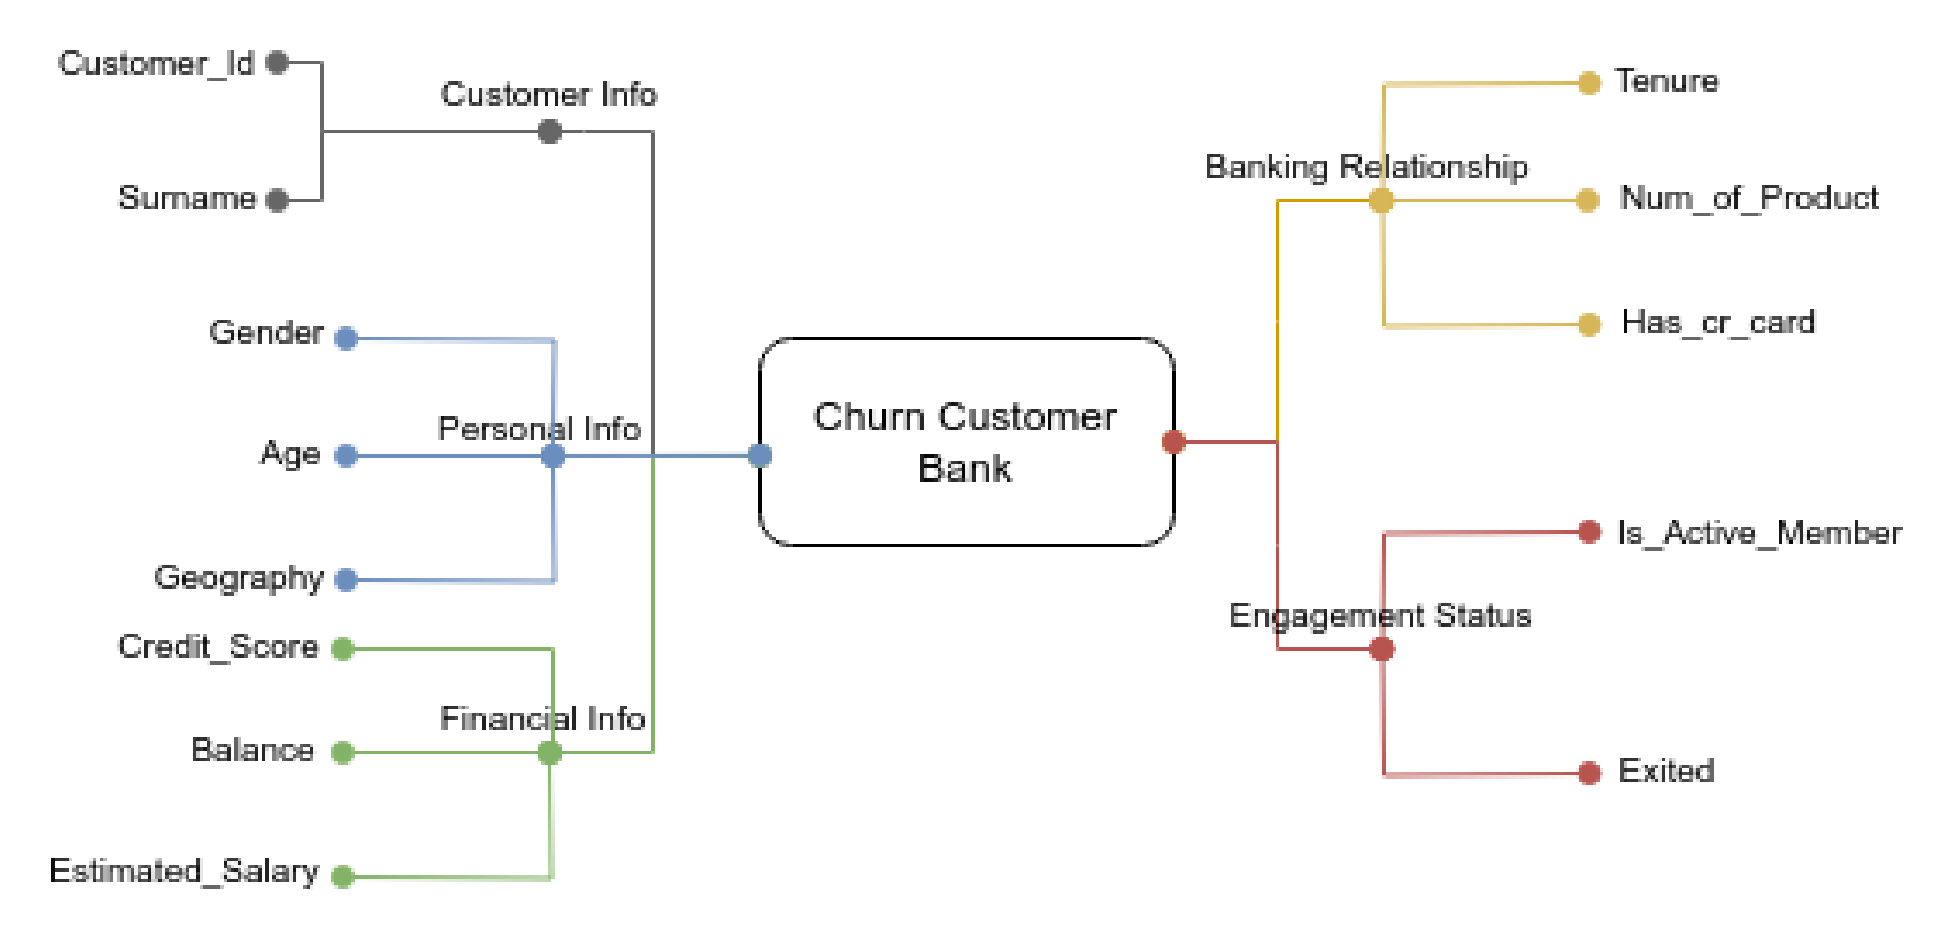

In [27]:
# Display the Image
img = mpimg.imread('Churn_Customer_Bank-mindmap.png')
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## 2.2 Hypothesis Creation

### 2.2.1 Customer Info

- Nasabah dengan nama belakang yang lebih umum memiliki tingkat churn 20% lebih tinggi dibandingkan dengan Nasabah yang memiliki nama belakang lebih unik.

### 2.2.2 Personal Info

-  Nasabah yang berusia di bawah 25 tahun memiliki tingkat churn 25% lebih tinggi dibandingkan dengan Nasabah yang berusia 30 tahun ke atas.
- Nasabah perempuan memiliki tingkat churn 18%.
- Nasabah yang berasal dari France memiliki tingkat churn yang lebih tinggi 15% dibandingkan dengan Nasabah yang berasal dari Germany.
- Nasabah yang berusia lebih tua (di atas 50 tahun) lebih jarang churn karena kecenderungan mereka untuk lebih loyal terhadap bank.
- Nasabah yang lebih muda (di bawah 30 tahun) lebih aktif dalam menggunakan aplikasi mobile bank dan cenderung lebih banyak churn karena tidak merasa terikat dengan layanan.

### 2.2.3 Financial Info

- Nasabah dengan saldo rekening kurang dari 1.000 Euro memiliki tingkat churn sekitar 25%, sementara Nasabah dengan saldo lebih dari 1.000 Euro hanya memiliki tingkat churn sekitar 10%.
- Nasabah dengan skor kredit di bawah 600 cenderung churn sekitar 20%.
- Nasabah dengan estimasi gaji yang lebih tinggi cenderung lebih setia dan lebih jarang churn.
- Nasabah dengan saldo lebih dari 10.000 Euro memiliki tingkat churn sekitar 5%
- Nasabah dengan kredit yang lebih sering gagal bayar cenderung lebih mungkin untuk churn, karena ketidakpuasan terhadap layanan bank.

### 2.2.3 Banking Relationship

- Nasabah dengan tenure lebih dari 5 tahun memiliki tingkat churn sekitar 5%, sementara Nasabah dengan tenure kurang dari 1 tahun memiliki tingkat churn sekitar 20%.
- Nasabah yang memiliki lebih dari satu produk bank memiliki churn sekitar 25%.
- Nasabah yang memiliki kartu kredit memiliki tingkat churn sekitar 10%, sementara Nasabah yang tidak memiliki kartu kredit cenderung churn sekitar 20%
- Nasabah yang menggunakan lebih dari satu jenis produk bank memiliki kemungkinan lebih rendah untuk churn karena lebih banyak terikat pada bank.
- Nasabah dengan produk pinjaman atau kredit yang merasa tidak puas dengan pengelolaan bank memiliki tingkat churn sekitar 25%

### 2.2.4 Engagement Status

- Nasabah yang tidak aktif memiliki tingkat churn sekitar 30%, sedangkan Nasabah yang aktif hanya memiliki tingkat churn sekitar 8%.
- Nasabah yang telah keluar cenderung tidak kembali ke bank meskipun mereka dipasarkan dengan penawaran baru.

## 2.3 Hypothesis List

- H1. Nasabah dengan nama belakang yang lebih umum memiliki tingkat churn 20% lebih tinggi dibandingkan dengan Nasabah yang memiliki nama belakang lebih unik.
- H2. Nasabah yang berasal dari France memiliki tingkat churn yang lebih tinggi 15% dibandingkan dengan Nasabah yang berasal dari Germany.
- H3. Nasabah dengan skor kredit di bawah 600 cenderung churn sekitar 20%.
- H4. Nasabah yang memiliki lebih dari satu produk bank memiliki churn lebih banyak.
- H5. Nasabah yang tidak aktif memiliki tingkat churn sekitar 30%, sedangkan Nasabah yang aktif hanya memiliki tingkat churn sekitar 8%.

# 3.0 Selecting Columns

---

In [28]:
# Menyalin dataframe
df3 = df2.copy()

## 3.1 Selecting Columns

In [29]:
# Menghapus kolom 'row_number' dan 'customer_id' dari DataFrame df3
df3 = df3.drop(columns=['row_number', 'customer_id'], axis=1)

## 3.2 Selecting Rows

Saya gunakan semua baris untuk data analisis

# 4.0 Exploratory Data Analysis

---

In [30]:
# Menyalin dataframe
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

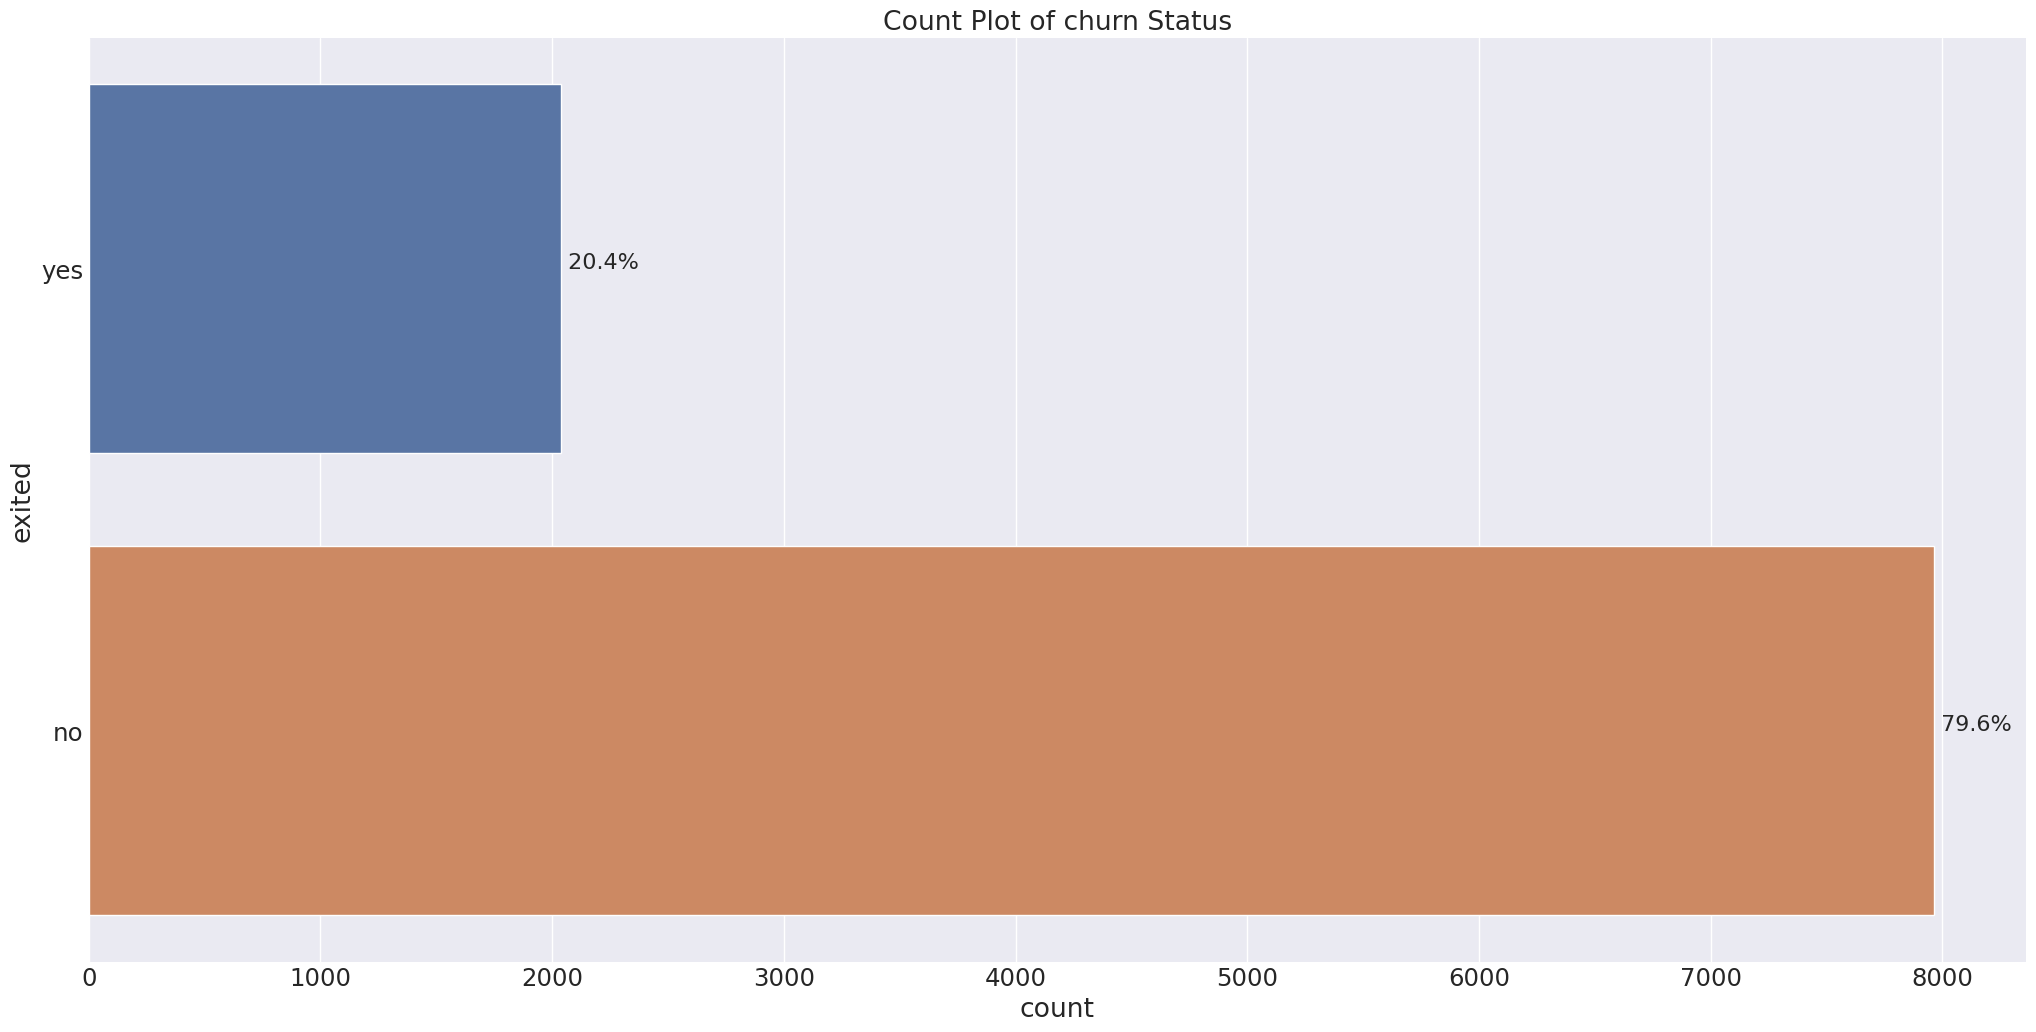

In [31]:
# Membuat count plot untuk variabel 'exited' pada DataFrame df4 dengan hue 'exited'
ax = sns.countplot(y='exited', data=df4, hue='exited');

# Menambahkan judul pada plot
ax.set_title('Count Plot of churn Status')

# Menghitung total jumlah data pada kolom 'exited'
total = df4['exited'].size

# Menambahkan persentase pada setiap batang (bar) di plot
for p in ax.patches:
    percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height()/2 
    ax.annotate(percentage, (x, y))


### 4.1.2 Numerical Variables

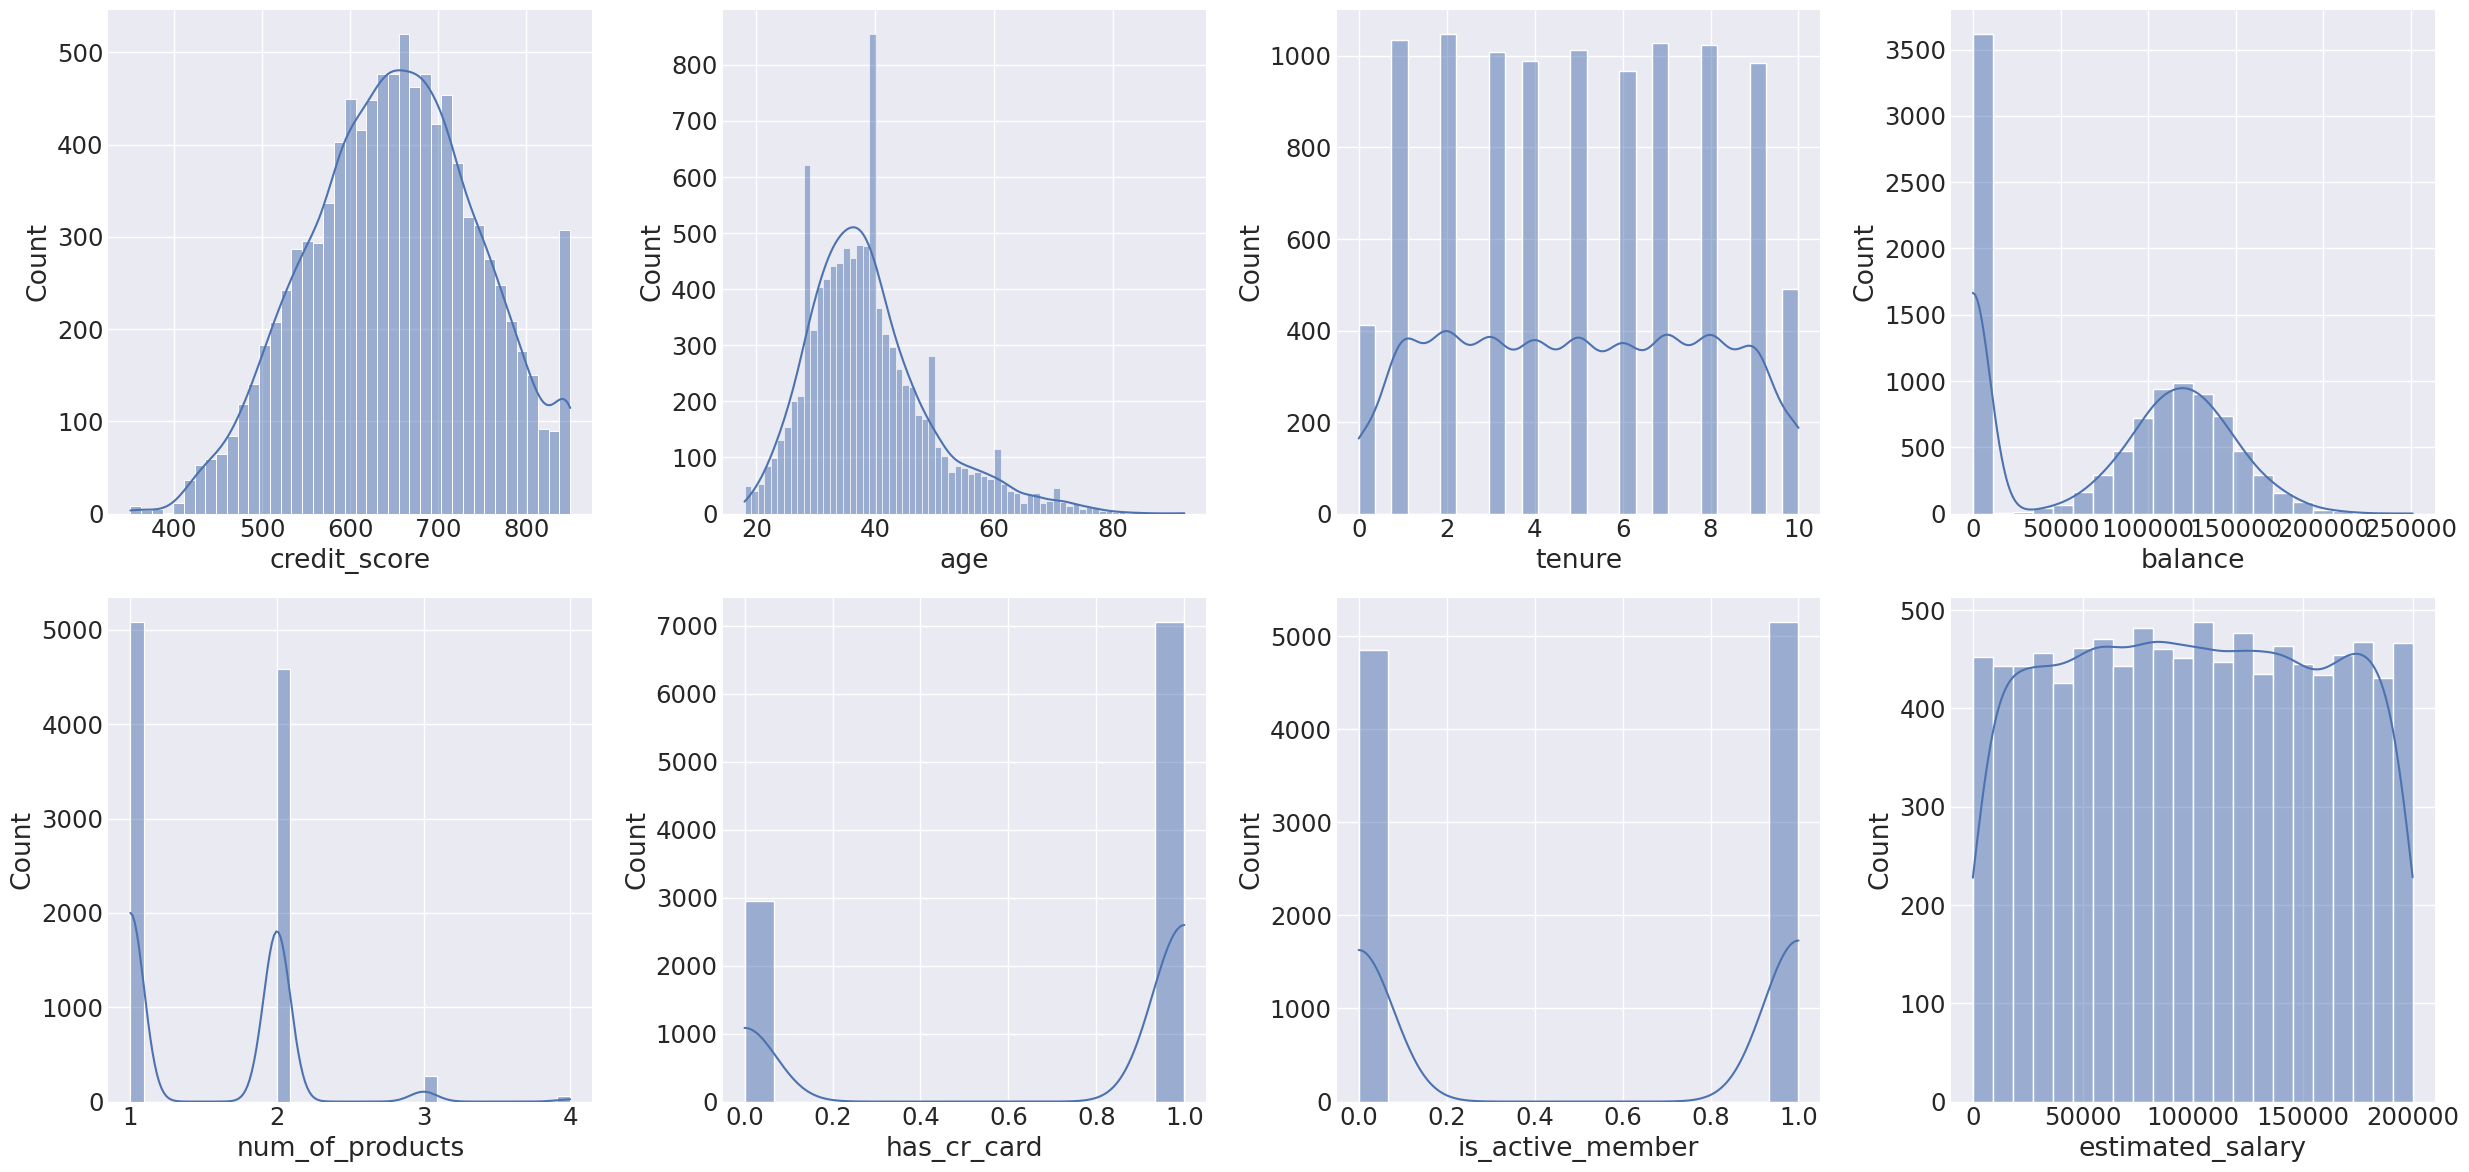

In [32]:
# Membuat plot numeric
Num_plot = univariate_plot(df4, type_attributes='numeric')
Num_plot

### 4.1.3 Categorical Variables

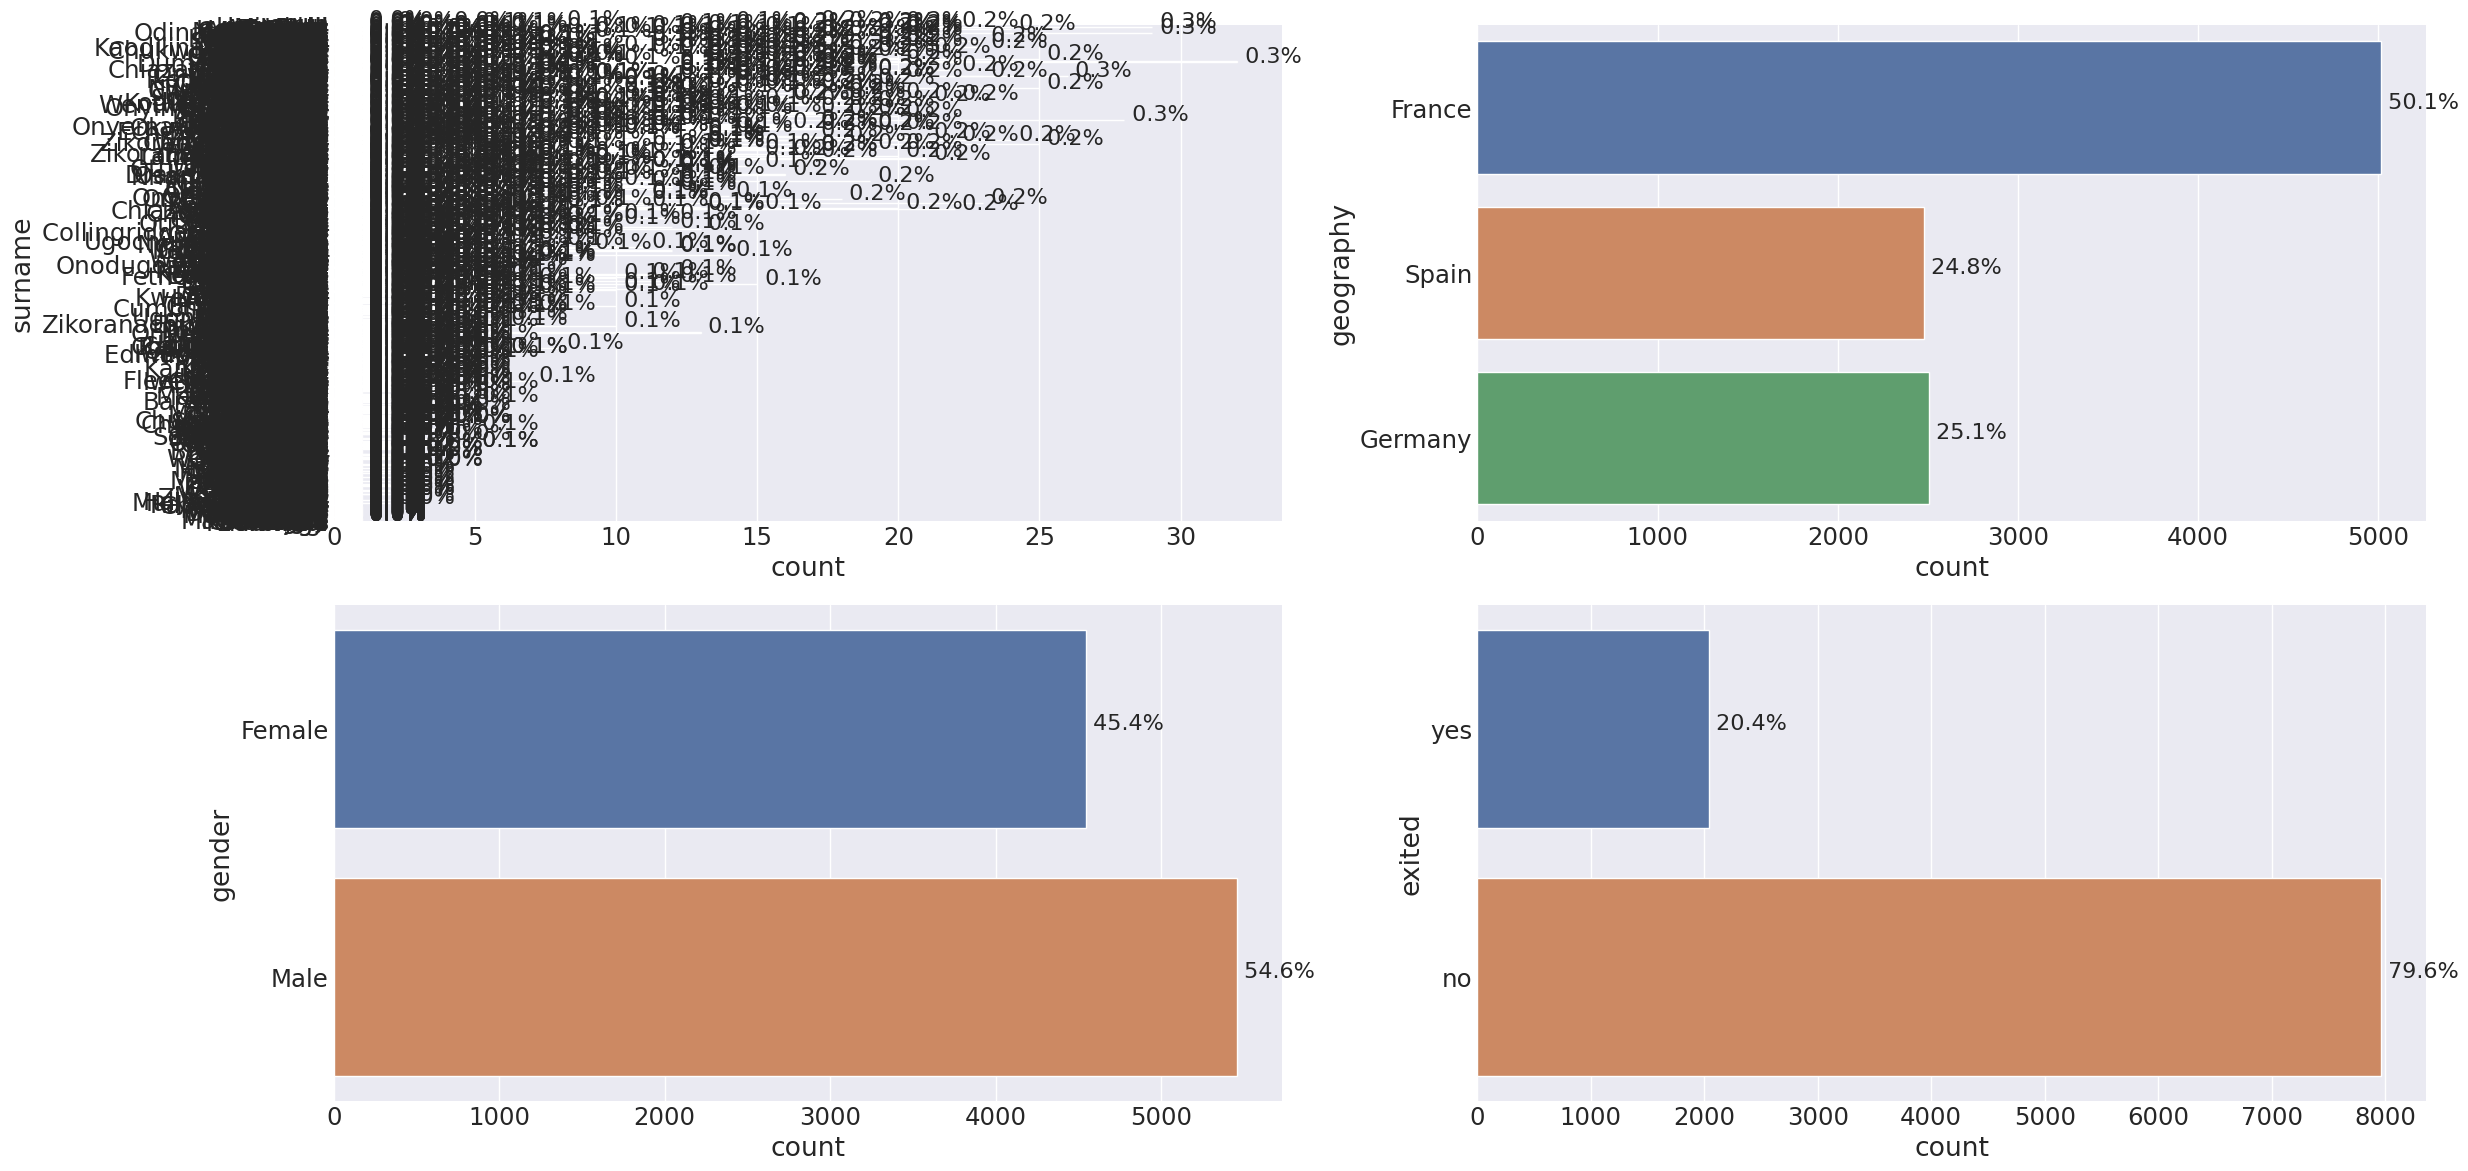

In [33]:
# Memanggil fungsi dan menyimpan plot
Cat_plot = univariate_plot(df4, type_attributes='categorical')
Cat_plot

## 4.2 Bivariate Analysis

#### H1. Nasabah dengan nama belakang yang lebih umum memiliki tingkat churn 20% lebih tinggi dibandingkan dengan Nasabah yang memiliki nama belakang lebih unik.

#### TRUE

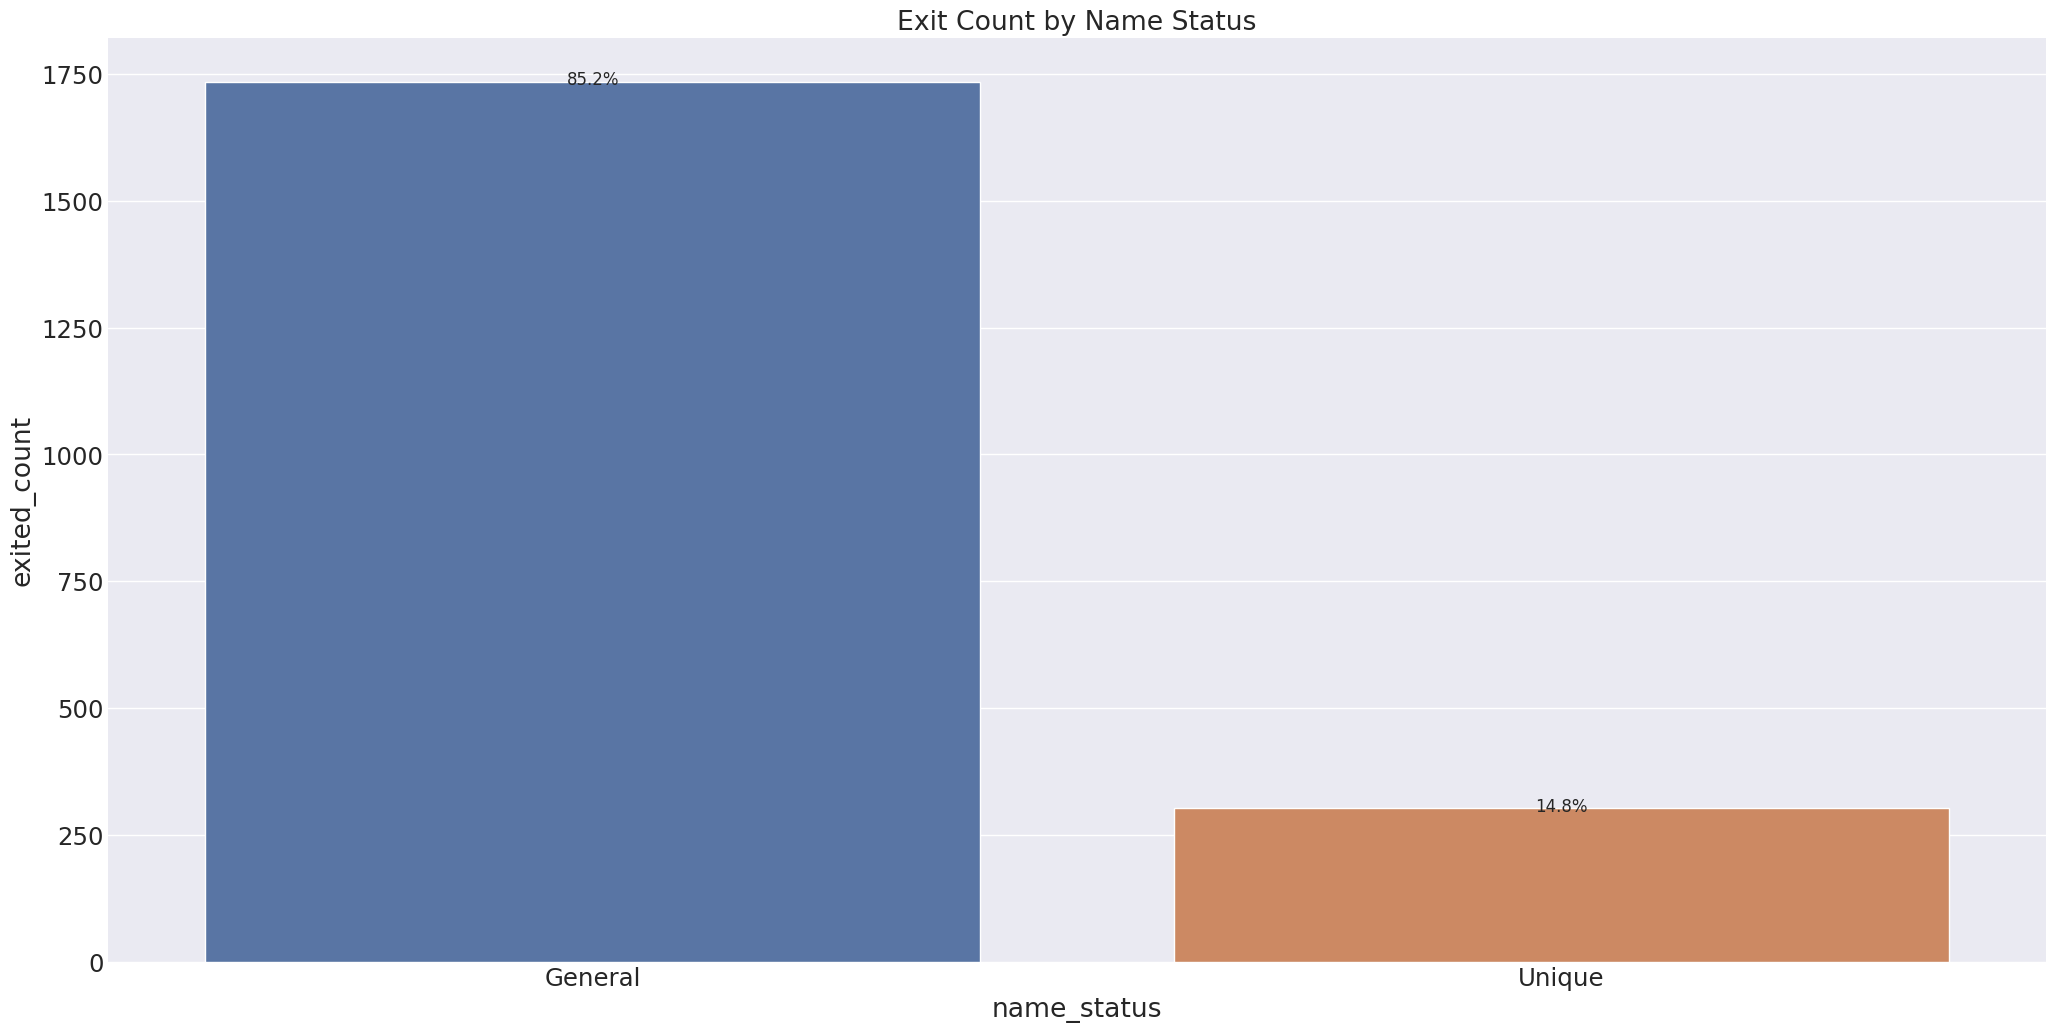

In [34]:
# Filter data yang statusnya 'yes' dan hitung kemunculan setiap nama
df4_data = df4[df4['exited'] == 'yes']

# Tentukan status 'name_status' berdasarkan apakah nama lebih sering muncul (lebih dari 1)
df4_data['name_status'] = df4_data['surname'].apply(
    lambda x: 'General' if df4['surname'].value_counts()[x] > 1 else 'Unique'
)

# Hitung jumlah berdasarkan 'name_status' dan persentase
exited_counts = df4_data['name_status'].value_counts().reset_index(name='exited_count')
exited_counts.columns = ['name_status', 'exited_count']
exited_counts['percentage'] = (exited_counts['exited_count'] / exited_counts['exited_count'].sum()) * 100

# Bar plot dengan persentase
ax = sns.barplot(x='name_status', y='exited_count', data=exited_counts, hue='name_status')
ax.set_title('Exit Count by Name Status')

# Menambahkan persentase ke dalam plot
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() + 5, 
            f'{p.get_height()/exited_counts["exited_count"].sum()*100:.1f}%', 
            ha="center", va="center", fontsize=12)


## H2. Nasabah yang berasal dari France memiliki tingkat churn yang lebih tinggi 15% dibandingkan dengan Nasabah yang berasal dari Germany.

#### FALSE

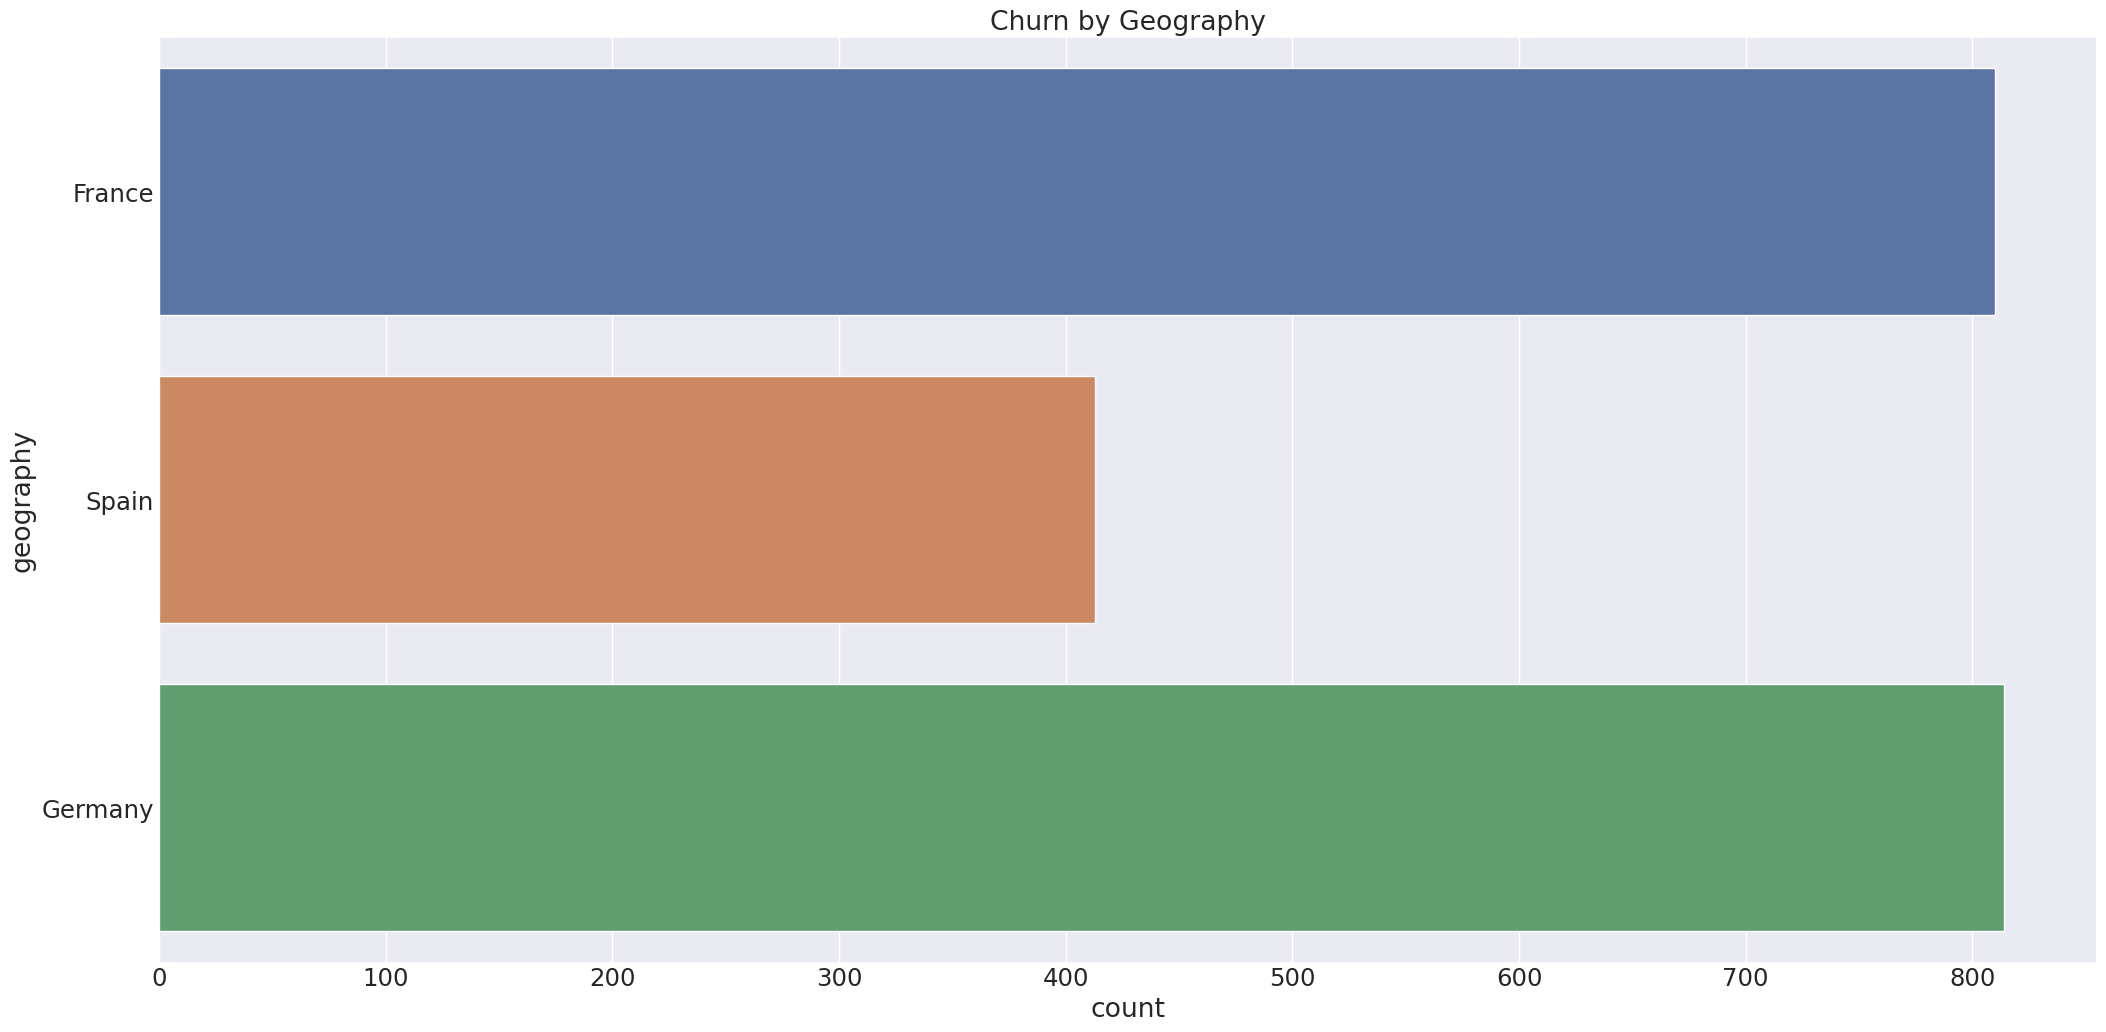

In [35]:
# Membuat count plot untuk variabel 'geography' berdasarkan data yang hanya memiliki nilai 'yes' pada kolom 'exited'
ax = sns.countplot(y='geography', hue='geography', data=df4[df4['exited'] == 'yes']);

# Menambahkan judul pada plot
ax.set_title('Churn by Geography');

#### H3. Nasabah dengan skor kredit di bawah 600 cenderung churn sekitar 20%

#### TRUE / FALSE

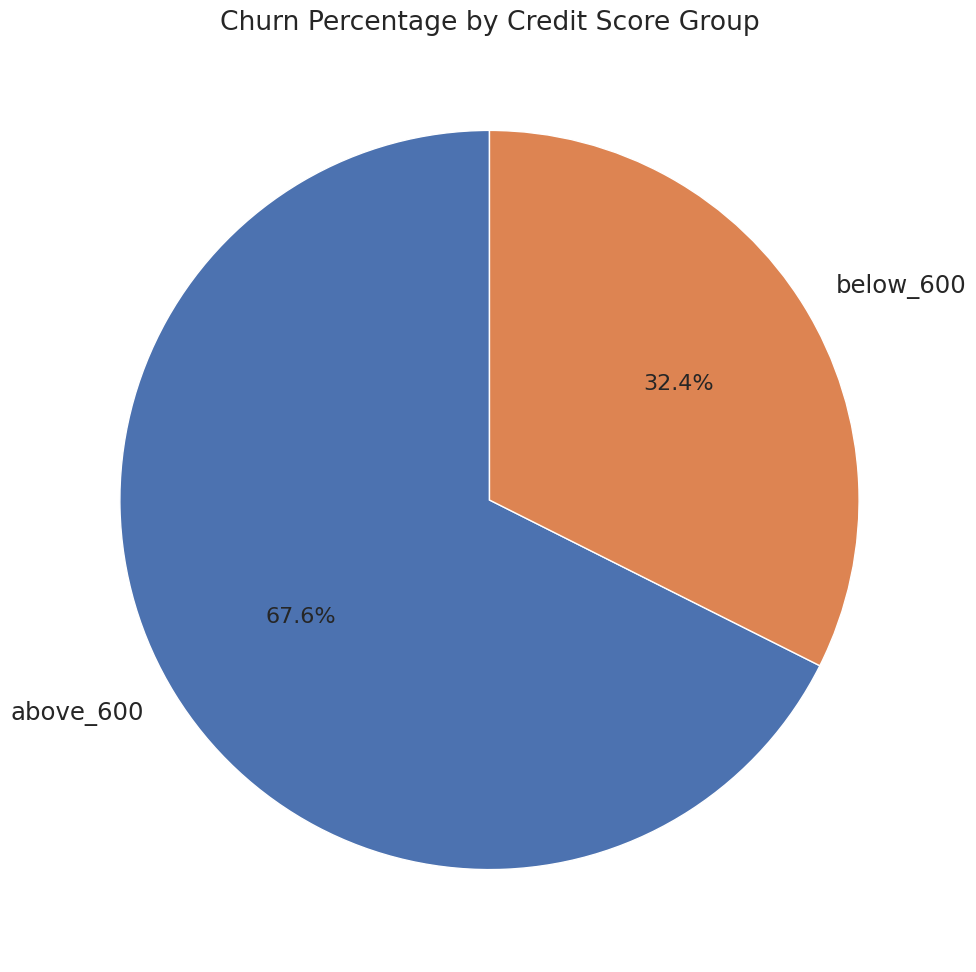

In [36]:
# Filter data untuk 'exited' == 'yes' dan tentukan 'Credit_score_status'
df4_data = df4[df4['exited'] == 'yes']
df4_data['Credit_score_status'] = df4_data['credit_score'].apply(
    lambda x: 'below_600' if x < 600 else 'above_600'
)

# Membuat pie chart untuk visualisasi
plt.pie(df4_data['Credit_score_status'].value_counts(), 
        labels=df4_data['Credit_score_status'].value_counts().index, 
        autopct='%1.1f%%', startangle=90)
plt.title('Churn Percentage by Credit Score Group');


#### H4. Pelanggan yang memiliki lebih dari satu produk bank memiliki churn lebih banyak.

#### FALSE

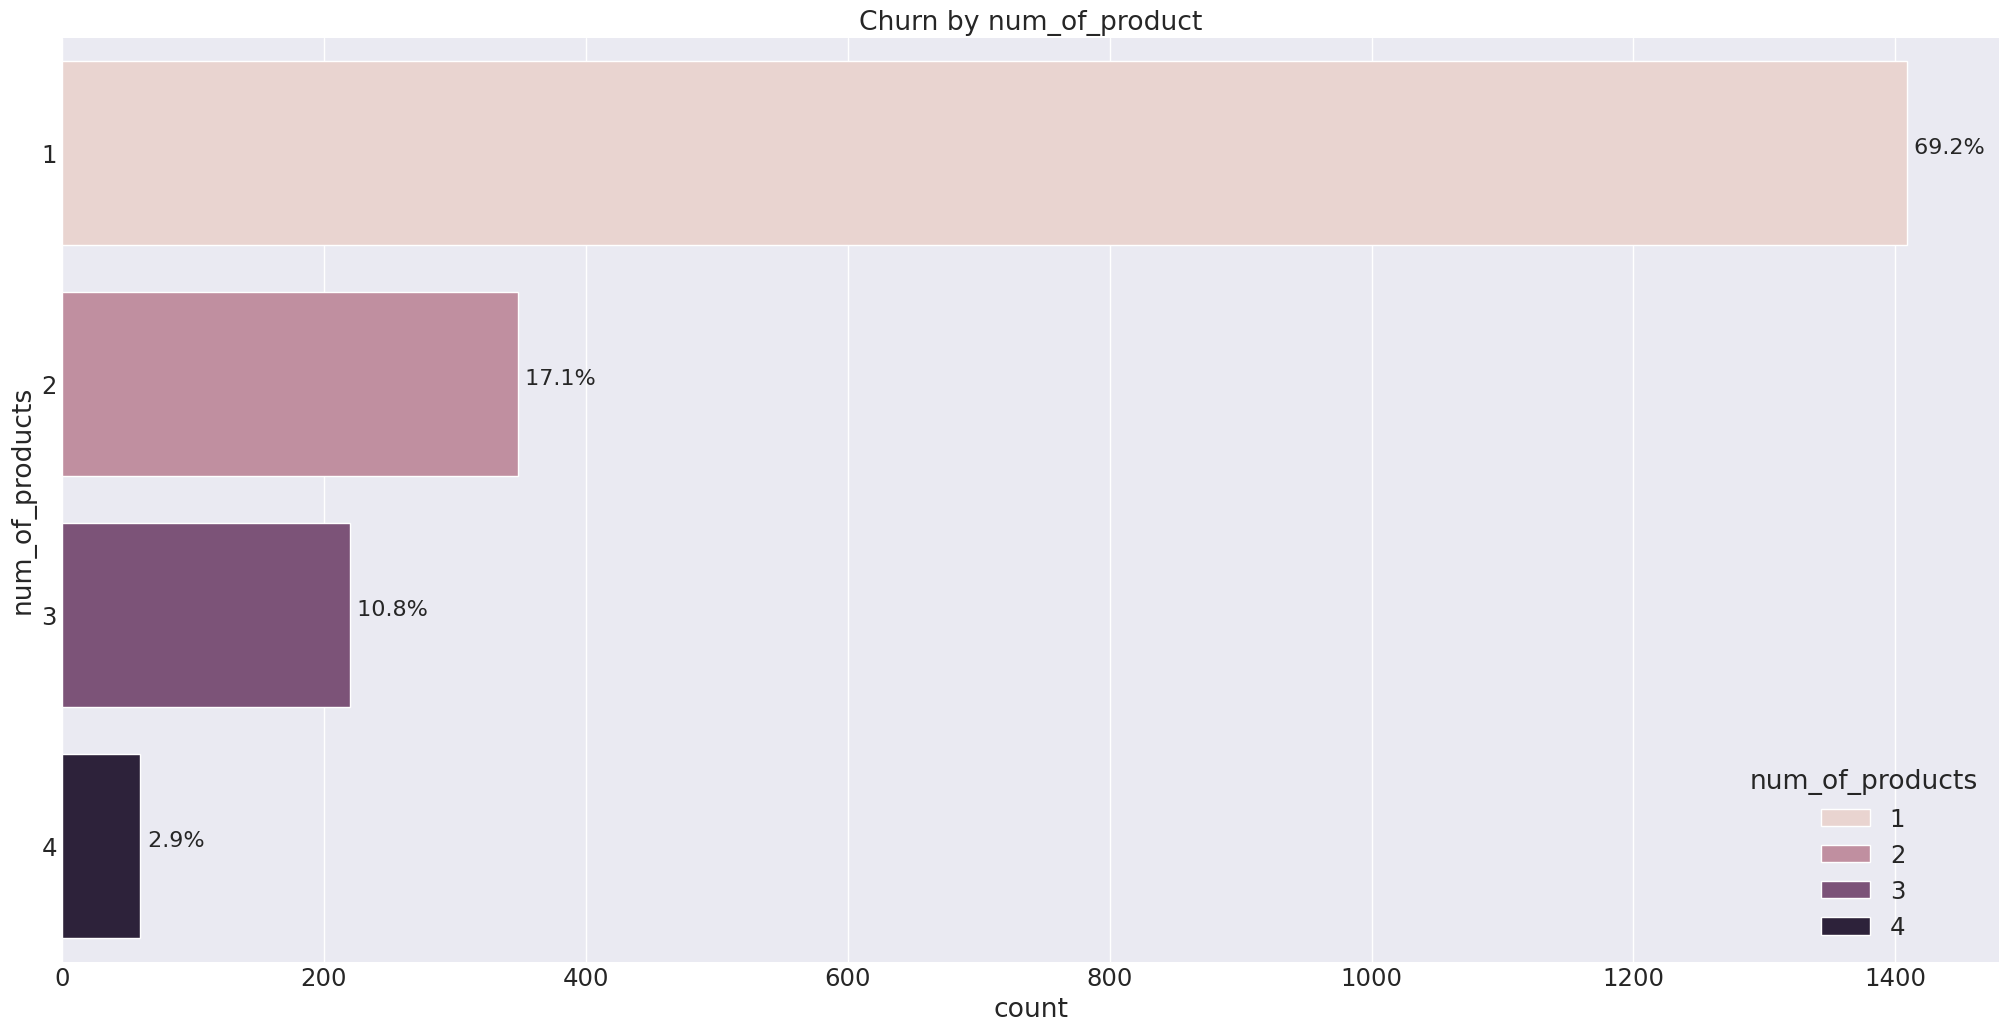

In [37]:
# Filter data untuk pelanggan yang telah keluar (exited = 'yes') dan buat count plot
ax = sns.countplot(y='num_of_products', data=df4[df4['exited'] == 'yes'], hue='num_of_products')

# Menambahkan persentase pada setiap batang (bar) di plot
total = df4[df4['exited'] == 'yes']['num_of_products'].size
for p in ax.patches:
    if p.get_width() > 0:
        ax.annotate(f' {100 * p.get_width() / total:.1f}%', 
                    (p.get_x() + p.get_width() + 0.02, p.get_y() + p.get_height()/2))

# Menambahkan judul pada plot
ax.set_title('Churn by num_of_product');


#### H5. Pelanggan yang tidak aktif memiliki tingkat churn sekitar 30%, sedangkan pelanggan yang aktif hanya memiliki tingkat churn sekitar 8%.

#### TRUE / FALSE

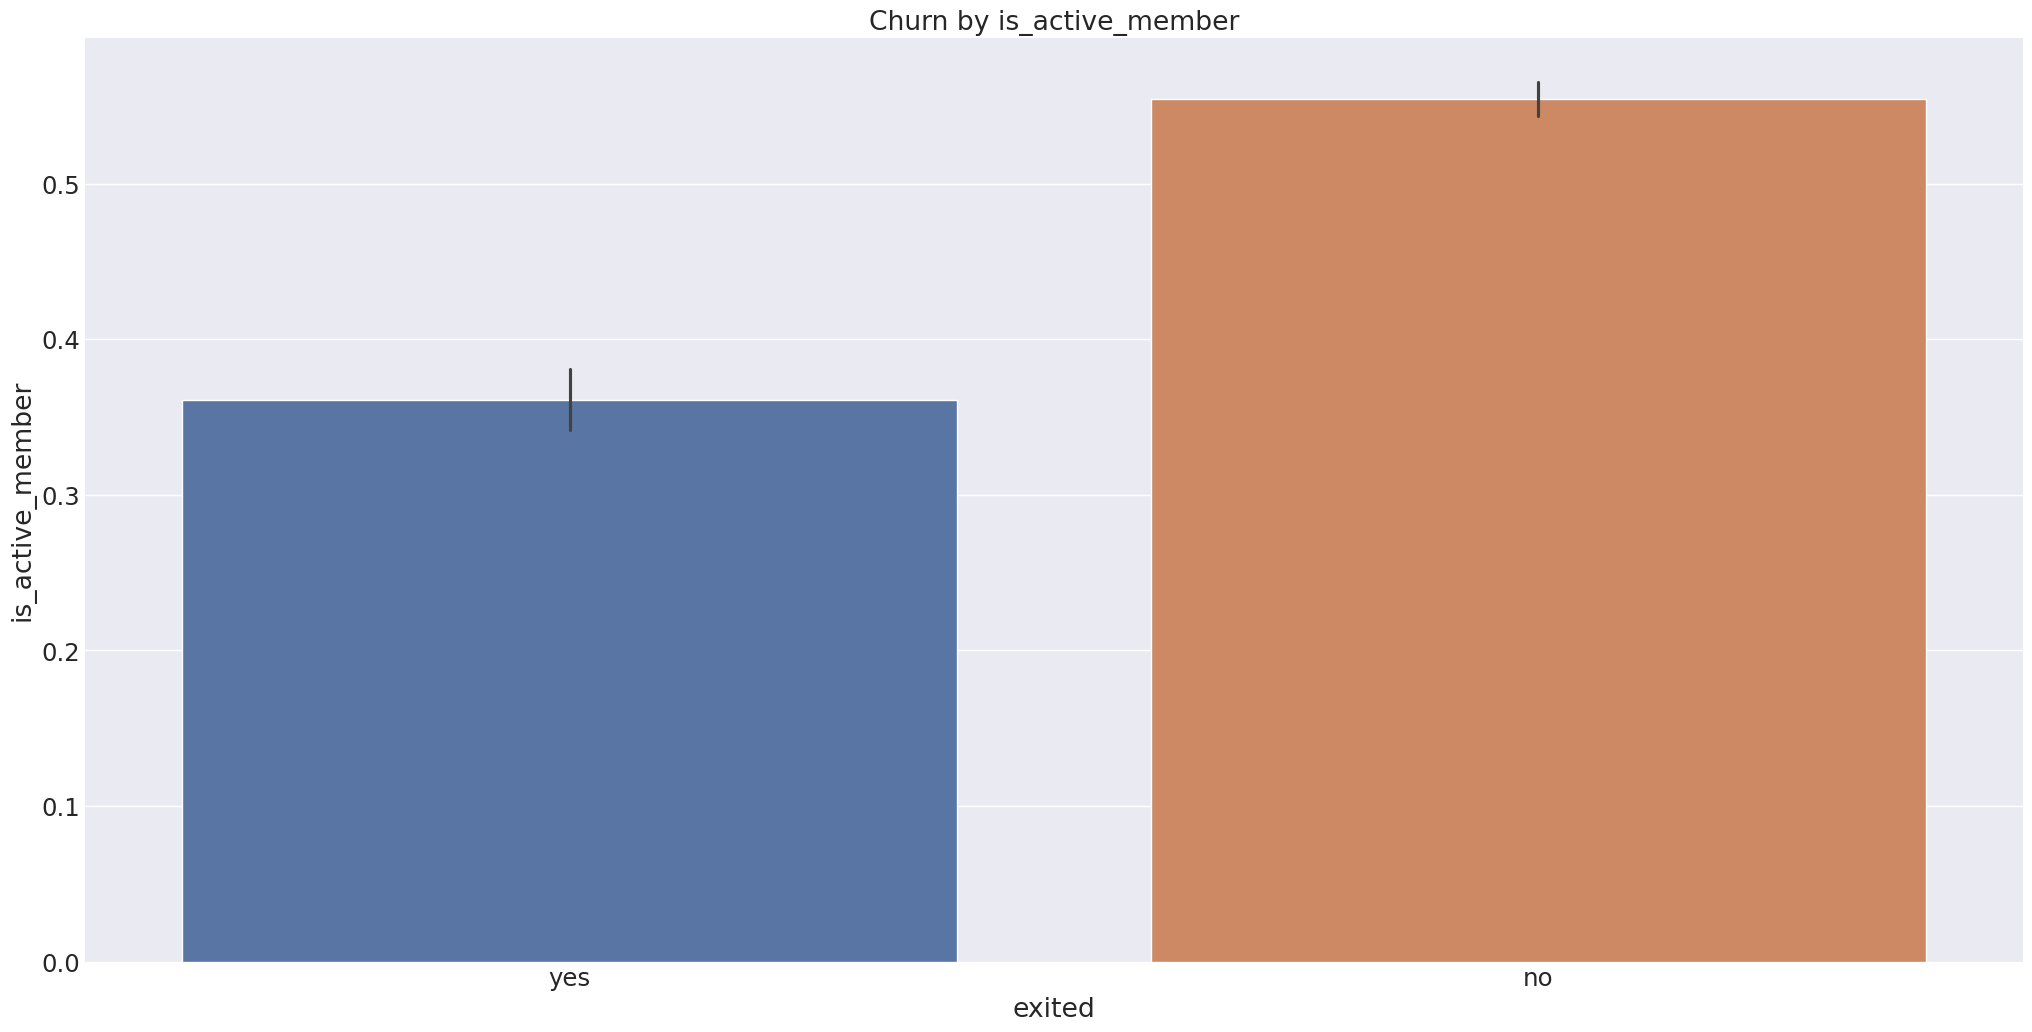

In [38]:
# Membuat bar plot untuk membandingkan status keanggotaan aktif ('is_active_member') berdasarkan status keluar ('exited')
ax = sns.barplot(x='exited', y='is_active_member', hue='exited', data=df4);

# Menambahkan judul pada plot
ax.set_title('Churn by is_active_member');

## 4.3 Multivariaty Analysis

### 4.3.1 Numerical Analysis

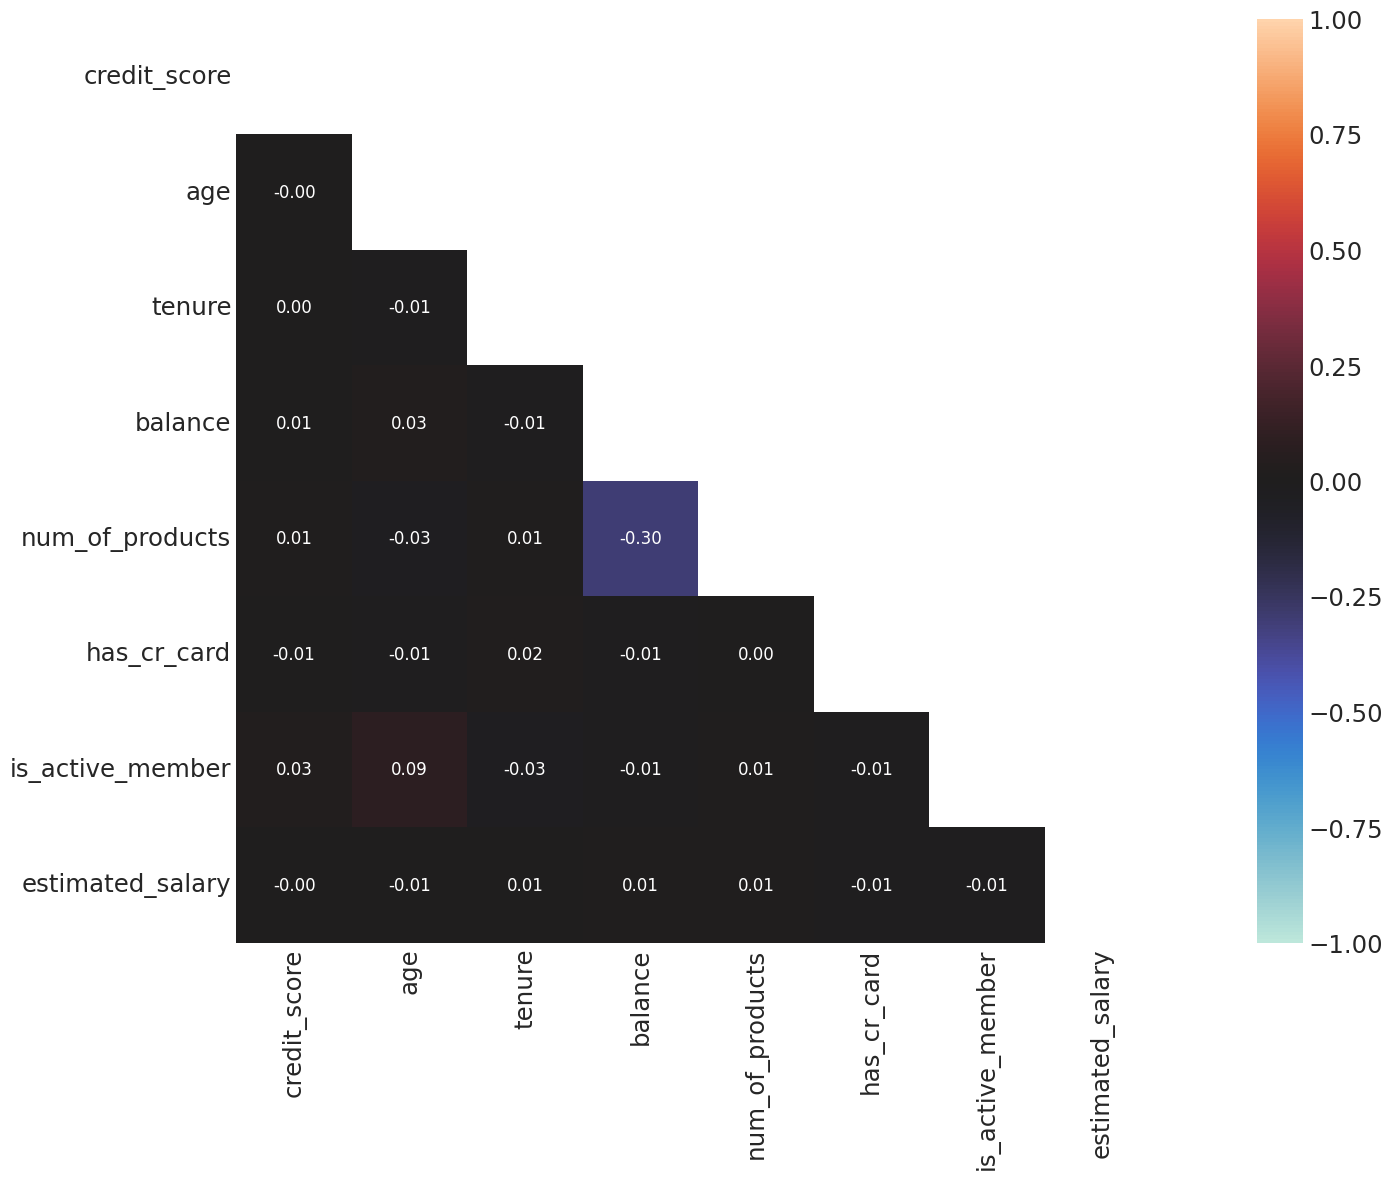

In [39]:
# Mendefinisikan numeric 
num_attributes = df4.select_dtypes(include=['number'])

# Menghitung nilai korelasi
corr = num_attributes.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Membuat heatmap
with sns.axes_style("white"):
    ax = sns.heatmap(corr, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True, fmt='.2f', annot_kws={'size': 12})

### 4.3.2 Categorical Variables

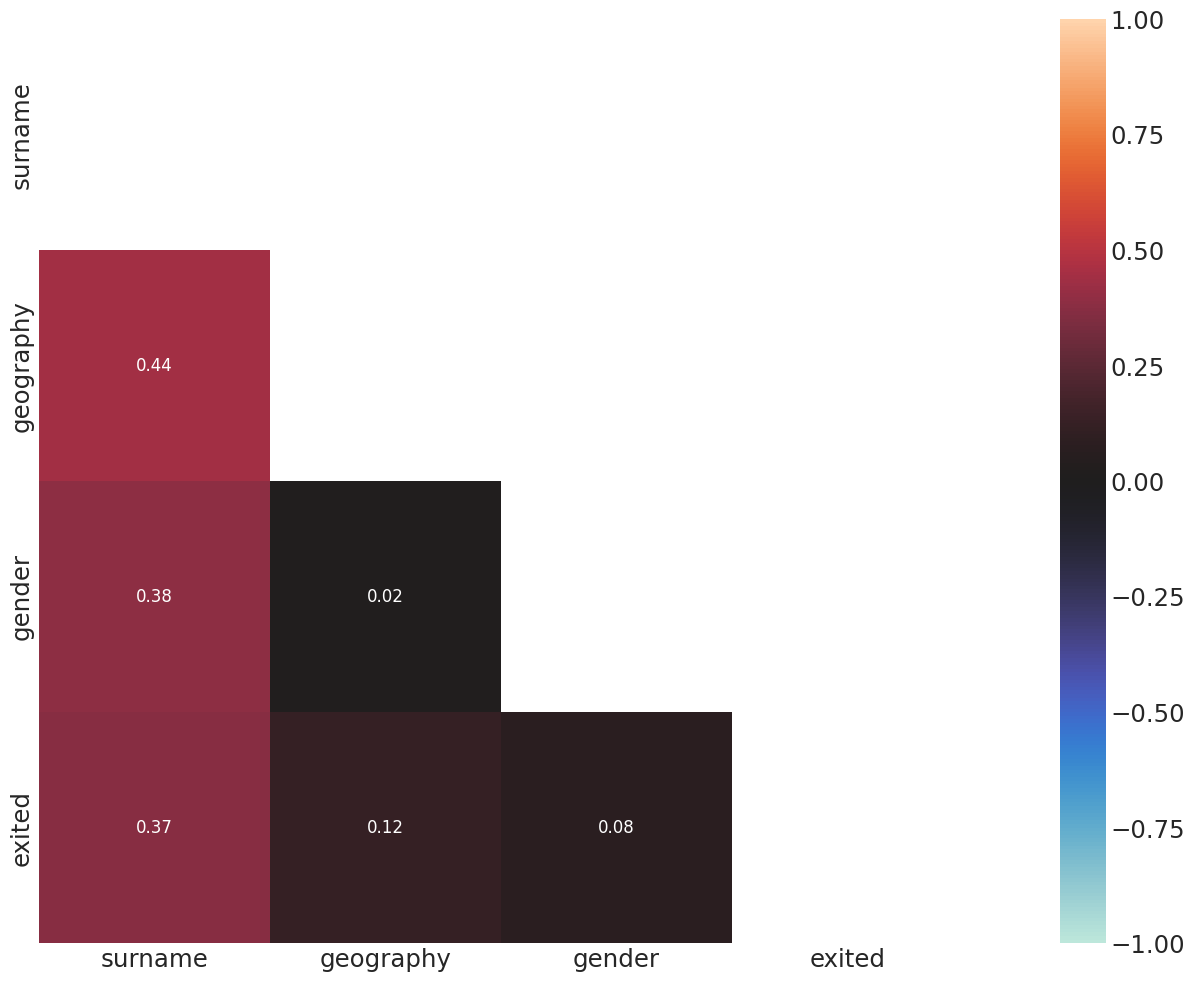

In [40]:
# Mendefinisikan cramers matrix
cramers_v_result = cramers_v_matrix(df4)

# Membuat mask
mask = np.zeros_like(cramers_v_result)
mask[np.triu_indices_from(mask)] = True

# Membuat heatmap
with sns.axes_style("white"):
    ax = sns.heatmap(cramers_v_result, annot=True, mask=mask, vmin=-1, center=0, vmax=1, square=True, fmt='.2f', annot_kws={'size': 12})

# 5.0 Data Preparation

---

In [41]:
# Menyalin data
df5 = df4.copy()

## 5.1 Splitting into Train, Valid and Test

In [42]:
# Hapus beberapa kolom yang tidak diperlukan
X = df5.drop(columns=['surname', 'exited'], axis=1)

# Membuat target vektor, mengubah 'yes' menjadi '1' dan 'no' menjadi '0'
y = df5['exited'].map({'yes': 1, 'no': 0})

In [43]:
# Membuat training dan testing subset (training 80% testing 20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [44]:
# Split training data menjadi 80% training dan 20% validasi
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

## 5.2 One Hot Encoder

In [45]:
# Inisialisasi OneHotEncoder untuk kolom-kolom kategorikal tertentu
ohe = ce.OneHotEncoder(cols=['geography', 'gender'], use_cat_names=True)

# Terapkan OneHotEncoder pada data pelatihan (X_train) dan simpan hasilnya
X_train = ohe.fit_transform(X_train)

# Terapkan OneHotEncoder pada data validasi (X_valid) tanpa fitting ulang
X_valid = ohe.transform(X_valid)

# Terapkan OneHotEncoder pada data sementara (X_temp) dan simpan hasilnya
X_temp = ohe.fit_transform(X_temp)

# Terapkan OneHotEncoder pada data uji (X_test) tanpa fitting ulang
X_test = ohe.transform(X_test)

## 5.3 Rescalling

In [46]:
# Tentukan kolom numerik yang akan diskalakan
num_columns = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

# Buat objek Min-Max scaler untuk melakukan normalisasi
scaler = MinMaxScaler()

# Salin data sementara untuk proses skala
X_params = X_temp.copy()

# Latih scaler pada data pelatihan dan skalakan kolom numerik
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

# Skalakan kolom numerik di data validasi menggunakan scaler yang telah dilatih pada data pelatihan
X_valid[num_columns] = scaler.transform(X_valid[num_columns])

# Skalakan kolom numerik di data sementara
X_params[num_columns] = scaler.fit_transform(X_temp[num_columns])

# Skalakan kolom numerik di data uji menggunakan scaler yang diterapkan pada data sementara
X_test[num_columns] = scaler.transform(X_test[num_columns])

# 6.0 Feature Selection

---

## 6.1 Boruta

In [47]:
X_boruta = X_params.values
y_boruta = y_temp.values.ravel()

In [48]:
boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
boruta.fit(X_boruta, y_boruta)

BorutaPy(estimator=RandomForestClassifier(n_estimators=31,
                                          random_state=RandomState(MT19937) at 0x7F95B0B9DE40),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F95B0B9DE40)

### 6.1.1 Best Features

In [49]:
cols_selected_boruta = boruta.support_.tolist()

In [50]:
columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [51]:
columns_selected

['age', 'balance', 'num_of_products', 'estimated_salary']

In [52]:
# Memeriksa ranking fitur
ranking = boruta.ranking_
ranking_df = pd.DataFrame({
    'Feature': X_params.columns,
    'Ranking': ranking
})
ranking_df = ranking_df.sort_values(by='Ranking')
print(ranking_df)

              Feature  Ranking
6                 age        1
8             balance        1
9     num_of_products        1
12   estimated_salary        1
0        credit_score        2
7              tenure        3
11   is_active_member        4
2   geography_Germany        5
10        has_cr_card        6
1    geography_France        7
4         gender_Male        8
3     geography_Spain        9
5       gender_Female       10


In [53]:
# [
#    'credit_score', 'geography_Spain', 'geography_Germany', 'geography_France', 
#    'gender_Male', 'gender_Female', 'age', 'tenure',
#    'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary'     
# ]

In [54]:
final_columns_selected = [
    'age', 'balance', 'num_of_products', 'estimated_salary',
    'credit_score', 'tenure', 'is_active_member'
]


# 7.0 Machine Learning Modeling

---

In [55]:
# Memilih kolom yang dipilih dari dataframe
X_train_cs = X_train[final_columns_selected]
X_valid_cs = X_valid[final_columns_selected]

X_temp_cs = X_temp[final_columns_selected]
X_test_cs = X_test[final_columns_selected]

X_params_cs = X_params[final_columns_selected]

## 7.1 Baseline

In [56]:
# Inisialisasi DummyClassifier dengan strategi 'stratified' (membuat prediksi acak berdasarkan distribusi kelas)
dummy = DummyClassifier(strategy='stratified')

# Latih model DummyClassifier menggunakan data pelatihan
dummy.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model DummyClassifier
y_pred_dummy = dummy.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_dummy = dummy.predict_proba(X_valid_cs)[:, 1]

In [57]:
# Menghitung skor evaluasi model DummyClassifier menggunakan fungsi ml_scores
dummy_results = ml_scores('dummy', 'Imbalanced_Classification', y_valid, y_pred_dummy, y_pred_prob_dummy)

# Menampilkan hasil evaluasi model DummyClassifier
dummy_results

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
dummy,0.488,0.184,0.181,0.183,0.287,-0.024,-0.024


### 7.1.1 Classification Report

In [58]:
# Menampilkan data klasifikasi
print(classification_report(y_valid, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1274
           1       0.18      0.18      0.18       326

    accuracy                           0.67      1600
   macro avg       0.49      0.49      0.49      1600
weighted avg       0.67      0.67      0.67      1600



### 7.1.2 Cross Validation

In [59]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
dummy_cv = ml_cv_results('dummy', 'Imbalanced_Classification', dummy, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
dummy,0.501 +/- 0.013,0.205 +/- 0.02,0.209 +/- 0.016,0.207 +/- 0.018,0.281 +/- 0.009,0.001 +/- 0.026,0.001 +/- 0.026


### 7.1.3 Confusion Matrix

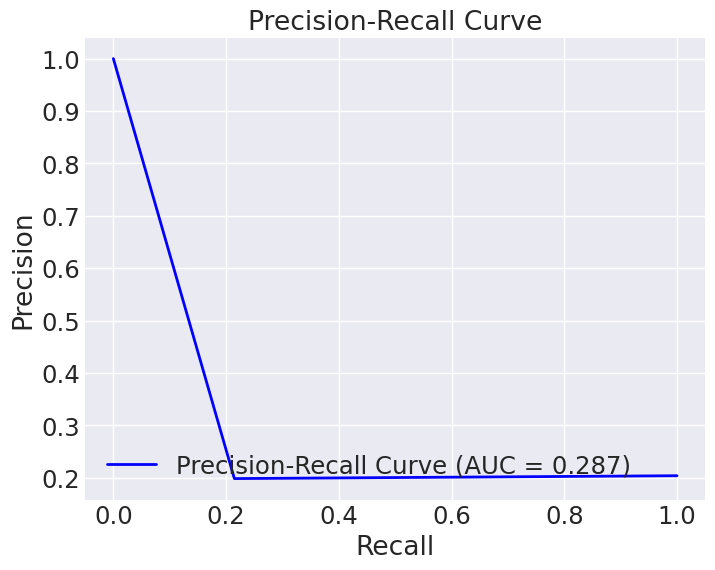

In [60]:
# Membuat plot precision-recall dengan plot_ml
dummy_plot = plot_ml(X_valid_cs, y_valid, y_pred_dummy, y_pred_prob_dummy, 'Imbalanced_Classification', 'Precision-Recall', dummy)

# Menampilkan hasil plot
dummy_plot

## 7.2 Logistic Regression

In [61]:
# Inisialisasi Logistic Regression 
lg = LogisticRegression()

# Latih model Logistic Regression menggunakan data pelatihan
lg.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model Logistic Regression
y_pred_lg = lg.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_lg = lg.predict_proba(X_valid_cs)[:, 1]

In [62]:
# Menghitung skor evaluasi model Logistic Regression menggunakan fungsi ml_scores
lg_results = ml_scores('Logistic Regression', 'Imbalanced_Classification', y_valid, y_pred_lg, y_pred_prob_lg)

# Menampilkan hasil evaluasi model Logistic Regression
lg_results

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
Logistic Regression,0.557,0.642,0.132,0.219,0.452,0.161,0.227


### 7.2.1 Classification Report

In [63]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_lg))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.82      0.98      0.13      0.89      0.36      0.14      1274
          1       0.64      0.13      0.98      0.22      0.36      0.12       326

avg / total       0.78      0.81      0.30      0.75      0.36      0.14      1600



### 7.2.2 Cross Validation

In [64]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
lg_cv = ml_cv_results('Logistic Regression', 'Imbalanced_Classification', lg, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
Logistic Regression,0.559 +/- 0.008,0.603 +/- 0.043,0.142 +/- 0.016,0.23 +/- 0.023,0.434 +/- 0.027,0.165 +/- 0.022,0.223 +/- 0.026


### 7.2.3 Precision-Recall Curve

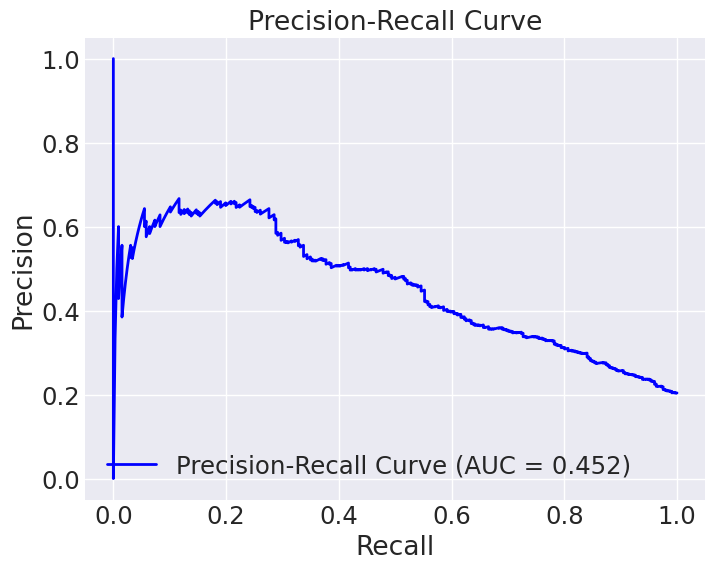

In [65]:
# Membuat plot precision-recall dengan plot_ml
lg_plot = plot_ml(X_valid_cs, y_valid, y_pred_lg, y_pred_prob_lg, 'Imbalanced_Classification', 'Precision-Recall', lg)

# Menampilkan hasil plot
lg_plot

## 7.3 K Nearest Neighbors

In [66]:
# Inisialisasi K Nearest Neighbors 
knn = KNeighborsClassifier()

# Latih model K Nearest Neighbors menggunakan data pelatihan
knn.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model K Nearest Neighbors
y_pred_knn = knn.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_knn = knn.predict_proba(X_valid_cs)[:, 1]

In [67]:
# Menghitung skor evaluasi model K Nearest Neighbors menggunakan fungsi ml_scores
knn_results = ml_scores('K Nearest Neighbors', 'Imbalanced_Classification', y_valid, y_pred_knn, y_pred_prob_knn)

# Menampilkan hasil evaluasi model Logistic Regression
knn_results

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
K Nearest Neighbors,0.673,0.66,0.399,0.497,0.595,0.406,0.424


### 7.3.1 Classification Report

In [68]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_knn))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.95      0.40      0.90      0.61      0.40      1274
          1       0.66      0.40      0.95      0.50      0.61      0.36       326

avg / total       0.82      0.84      0.51      0.82      0.61      0.39      1600



### 7.3.2 Cross Validation

In [69]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
knn_cv = ml_cv_results('K Nearest Neighbors', 'Imbalanced_Classification', knn, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
K Nearest Neighbors,0.654 +/- 0.016,0.639 +/- 0.017,0.361 +/- 0.036,0.46 +/- 0.029,0.553 +/- 0.028,0.367 +/- 0.028,0.389 +/- 0.024


### 7.3.3 Precision-Recall Curve

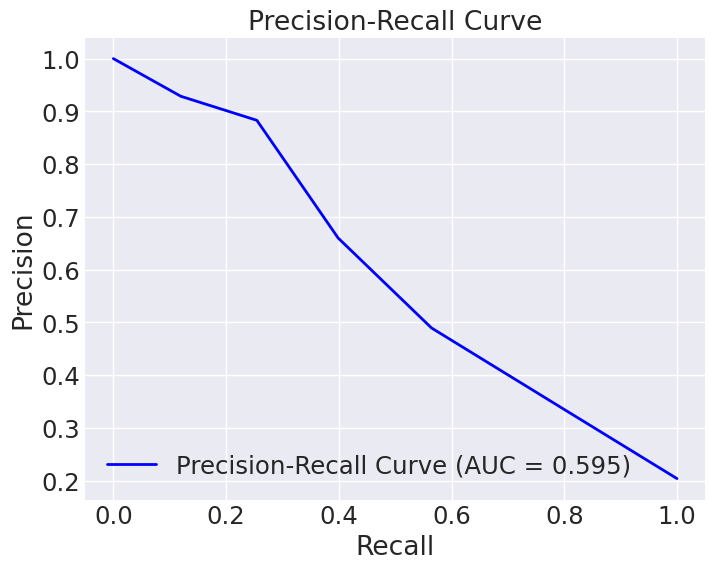

In [70]:
# Membuat plot precision-recall dengan plot_ml
knn_plot = plot_ml(X_valid_cs, y_valid, y_pred_knn, y_pred_prob_knn, 'Imbalanced_Classification', 'Precision-Recall', knn)

# Menampilkan hasil plot
knn_plot

## 7.4 Support Vector Machine

In [71]:
# Inisialisasi Support Vector Machine 
svm = SVC(class_weight='balanced', probability=True)

# Latih model Support Vector Machine menggunakan data pelatihan
svm.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model Support Vector Machine
y_pred_svm = svm.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_svm = svm.predict_proba(X_valid_cs)[:, 1]

In [72]:
# Menghitung skor evaluasi model Support Vector Machine menggunakan fungsi ml_scores
svm_results = ml_scores('SVM', 'Imbalanced_Classification', y_valid, y_pred_svm, y_pred_prob_svm)

# Menampilkan hasil evaluasi model Support Vector Machine
svm_results

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
SVM,0.758,0.468,0.727,0.57,0.61,0.428,0.447


### 7.4.1 Classification Report

In [73]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_svm))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.79      0.73      0.85      0.76      0.58      1274
          1       0.47      0.73      0.79      0.57      0.76      0.57       326

avg / total       0.83      0.78      0.74      0.79      0.76      0.58      1600



### 7.4.2 Cross Validation

In [74]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
svm_cv = ml_cv_results('SVM', 'Imbalanced_Classification', svm, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
SVM,0.752 +/- 0.009,0.447 +/- 0.004,0.739 +/- 0.025,0.557 +/- 0.009,0.626 +/- 0.024,0.406 +/- 0.01,0.43 +/- 0.013


### 7.4.3 Precision-Recall Curve

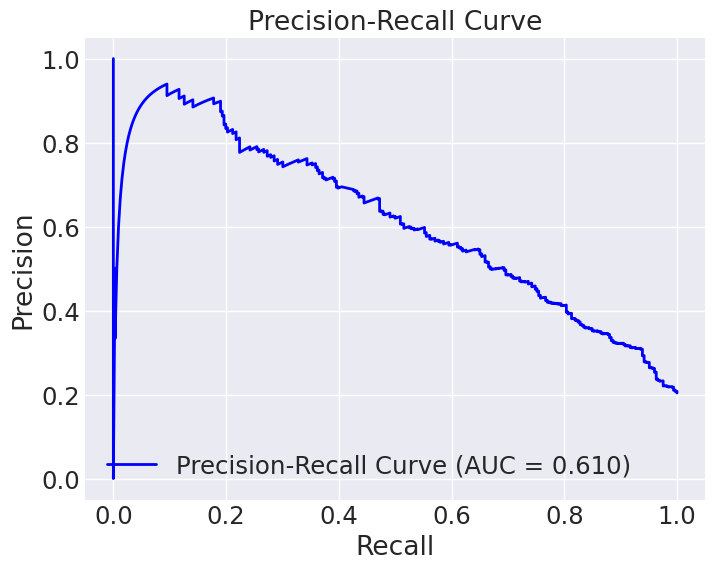

In [75]:
# Membuat plot precision-recall dengan plot_ml
svm_plot = plot_ml(X_valid_cs, y_valid, y_pred_svm, y_pred_prob_svm, 'Imbalanced_Classification', 'Precision-Recall', svm)

# Menampilkan hasil plot
svm_plot

## 7.5 Random Forest

In [76]:
# Inisialisasi Random Forest 
rf = RandomForestClassifier(class_weight='balanced')

# Latih model Random Forest menggunakan data pelatihan
rf.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model Random Forest
y_pred_rf = rf.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_rf = rf.predict_proba(X_valid_cs)[:, 1]

In [77]:
# Menghitung skor evaluasi model Random Forest menggunakan fungsi ml_scores
rf_results = ml_scores('Random Forest', 'Imbalanced_Classification', y_valid, y_pred_rf, y_pred_prob_rf)

# Menampilkan hasil evaluasi model Support Vector Machine
rf_results

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
Random Forest,0.687,0.751,0.408,0.529,0.656,0.45,0.48


### 7.5.1 Classification Report

In [78]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.97      0.41      0.91      0.63      0.42      1274
          1       0.75      0.41      0.97      0.53      0.63      0.37       326

avg / total       0.84      0.85      0.52      0.83      0.63      0.41      1600



### 7.5.2 Cross Validation

In [79]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
rf_cv = ml_cv_results('Random Forest', 'Imbalanced_Classification', rf, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
Random Forest,0.686 +/- 0.012,0.734 +/- 0.013,0.411 +/- 0.025,0.527 +/- 0.021,0.638 +/- 0.02,0.446 +/- 0.022,0.472 +/- 0.018


### 7.5.3 Precision-Recall Curve

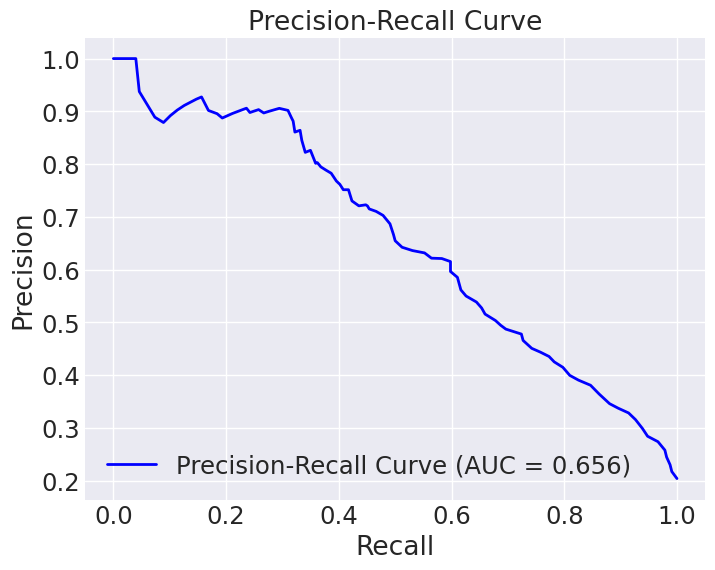

In [80]:
# Membuat plot precision-recall dengan plot_ml
rf_plot = plot_ml(X_valid_cs, y_valid, y_pred_rf, y_pred_prob_rf, 'Imbalanced_Classification', 'Precision-Recall', rf)

# Menampilkan hasil plot
rf_plot

## 7.6 XGBoost

In [81]:
# Inisialisasi XGBoost 
xgb = XGBClassifier()

# Latih model XGBoost menggunakan data pelatihan
xgb.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model XGBoost
y_pred_xgb = xgb.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_xgb = xgb.predict_proba(X_valid_cs)[:, 1]

In [82]:
# Menghitung skor evaluasi model XGBoost menggunakan fungsi ml_scores
xgb_results = ml_scores('XGBoost', 'Imbalanced_Classification', y_valid, y_pred_xgb, y_pred_prob_xgb)

# Menampilkan hasil evaluasi model Support Vector Machine
xgb_results

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
XGBoost,0.7,0.702,0.448,0.547,0.635,0.461,0.478


### 7.6.1 Classification Report

In [83]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_xgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.95      0.45      0.91      0.65      0.45      1274
          1       0.70      0.45      0.95      0.55      0.65      0.40       326

avg / total       0.84      0.85      0.55      0.84      0.65      0.44      1600



### 7.6.2 Cross Validation

In [84]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
xgb_cv = ml_cv_results('XGBoost', 'Imbalanced_Classification', xgb, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
XGBoost,0.696 +/- 0.016,0.667 +/- 0.03,0.45 +/- 0.029,0.537 +/- 0.028,0.631 +/- 0.025,0.446 +/- 0.033,0.459 +/- 0.032


### 7.6.3 Precision-Recall Curve

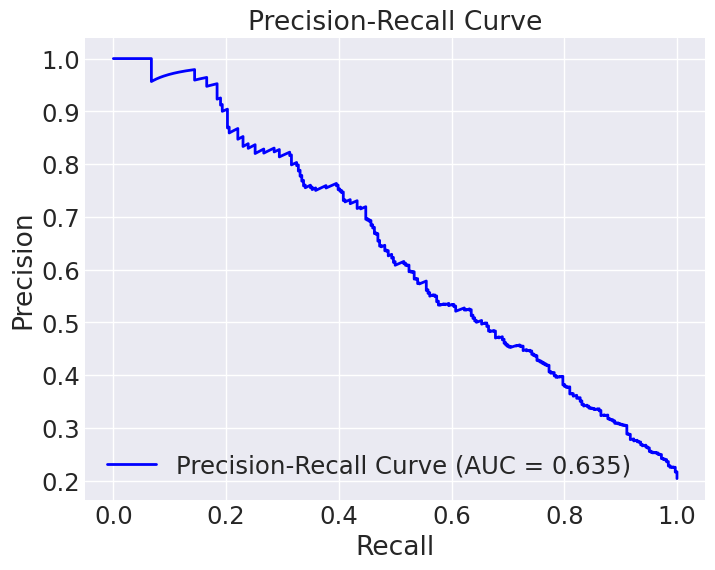

In [85]:
# Membuat plot precision-recall dengan plot_ml
xgb_plot = plot_ml(X_valid_cs, y_valid, y_pred_xgb, y_pred_prob_xgb, 'Imbalanced_Classification', 'Precision-Recall', xgb)

# Menampilkan hasil plot
xgb_plot

## 7.7 LightGBM

In [86]:
# Inisialisasi LightGBM 
lgb = LGBMClassifier()

# Latih model LightGBM menggunakan data pelatihan
lgb.fit(X_train_cs, y_train)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model LightGBM
y_pred_lgb = lgb.predict(X_valid_cs)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_lgb = lgb.predict_proba(X_valid_cs)[:, 1]

[LightGBM] [Info] Number of positive: 1304, number of negative: 5096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


In [87]:
# Menghitung skor evaluasi model LightGBM menggunakan fungsi ml_scores
lgb_results = ml_scores('LightGBM', 'Imbalanced_Classification', y_valid, y_pred_lgb, y_pred_prob_lgb)

# Menampilkan hasil evaluasi model Support Vector Machine
lgb_results

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
LightGBM,0.7,0.727,0.442,0.55,0.68,0.468,0.488


### 7.7.1 Classification Report

In [88]:
# Menampilkan data klasifikasi untuk data tidak seimbang
print(classification_report_imbalanced(y_valid, y_pred_lgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.96      0.44      0.91      0.65      0.44      1274
          1       0.73      0.44      0.96      0.55      0.65      0.40       326

avg / total       0.84      0.85      0.55      0.84      0.65      0.44      1600



### 7.7.2 Cross Validation

In [89]:
# Menghitung skor evaluasi model cross validation menggunakan fungsi ml_cv_results
lgb_cv = ml_cv_results('LightGBM', 'Imbalanced_Classification', lgb, X_temp_cs, y_temp)

# Menampilkan hasil evaluasi
lgb_cv

Fold K=1
[LightGBM] [Info] Number of positive: 1304, number of negative: 5096
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019
Fold K=2
[LightGBM] [Info] Number of positive: 1304, number of negative: 5096
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 845
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.3

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
LightGBM,0.698 +/- 0.017,0.715 +/- 0.011,0.441 +/- 0.038,0.545 +/- 0.03,0.653 +/- 0.022,0.461 +/- 0.031,0.481 +/- 0.026


### 7.7.3 Precision-Recall Curve

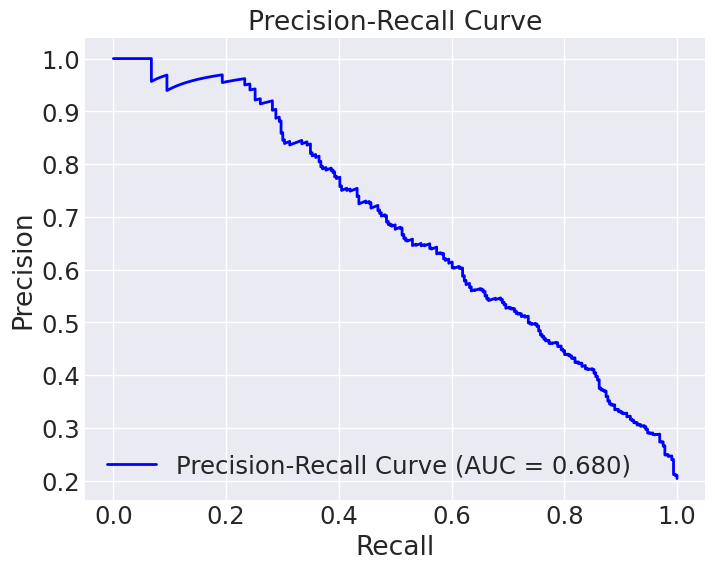

In [90]:
# Membuat plot precision-recall dengan plot_ml
lgb_plot = plot_ml(X_valid_cs, y_valid, y_pred_lgb, y_pred_prob_lgb, 'Imbalanced_Classification', 'Precision-Recall', lgb)

# Menampilkan hasil plot
lgb_plot

## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [91]:
# Penggabungan skor evaluasi
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lgb_results,
                                 svm_results])

# Mengurutkan model berdasarkan "Balanced Accuracy"
modeling_performance.sort_values(by="Balanced Accuracy", ascending=True)

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
dummy,0.488,0.184,0.181,0.183,0.287,-0.024,-0.024
Logistic Regression,0.557,0.642,0.132,0.219,0.452,0.161,0.227
K Nearest Neighbors,0.673,0.660,0.399,0.497,0.595,0.406,0.424
Random Forest,0.687,0.751,0.408,0.529,0.656,0.450,0.480
XGBoost,0.700,0.702,0.448,0.547,0.635,0.461,0.478
LightGBM,0.700,0.727,0.442,0.550,0.680,0.468,0.488
SVM,0.758,0.468,0.727,0.570,0.610,0.428,0.447


### 7.8.2 Cross Validation Performance

In [92]:
# Penggabungan skor evaluasi Cross Validation
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, lgb_cv, svm_cv])

# Mengurutkan model berdasarkan "Balanced Accuracy"
modeling_performance_cv.sort_values(by="Balanced Accuracy", ascending=True)

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
dummy,0.501 +/- 0.013,0.205 +/- 0.02,0.209 +/- 0.016,0.207 +/- 0.018,0.281 +/- 0.009,0.001 +/- 0.026,0.001 +/- 0.026
Logistic Regression,0.559 +/- 0.008,0.603 +/- 0.043,0.142 +/- 0.016,0.23 +/- 0.023,0.434 +/- 0.027,0.165 +/- 0.022,0.223 +/- 0.026
K Nearest Neighbors,0.654 +/- 0.016,0.639 +/- 0.017,0.361 +/- 0.036,0.46 +/- 0.029,0.553 +/- 0.028,0.367 +/- 0.028,0.389 +/- 0.024
Random Forest,0.686 +/- 0.012,0.734 +/- 0.013,0.411 +/- 0.025,0.527 +/- 0.021,0.638 +/- 0.02,0.446 +/- 0.022,0.472 +/- 0.018
XGBoost,0.696 +/- 0.016,0.667 +/- 0.03,0.45 +/- 0.029,0.537 +/- 0.028,0.631 +/- 0.025,0.446 +/- 0.033,0.459 +/- 0.032
LightGBM,0.698 +/- 0.017,0.715 +/- 0.011,0.441 +/- 0.038,0.545 +/- 0.03,0.653 +/- 0.022,0.461 +/- 0.031,0.481 +/- 0.026
SVM,0.752 +/- 0.009,0.447 +/- 0.004,0.739 +/- 0.025,0.557 +/- 0.009,0.626 +/- 0.024,0.406 +/- 0.01,0.43 +/- 0.013


# 8.0 Hyperparameter Tuning

---

In [93]:
# Menginisialisasi f1. Untuk Hyperparameter Tuning akan menggunakan f1 score
f1 = make_scorer(f1_score)

In [94]:
# Mendefinisikan dictionary 'params' yang berisi kombinasi hyperparameter untuk pencarian grid search
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'probability': [True, False]
}

In [95]:
# Membuat objek GridSearchCV untuk melakukan pencarian hyperparameter dengan cross-validation
gs = GridSearchCV(SVC(), 
                  param_grid=params, 
                  scoring=f1, 
                  cv=StratifiedKFold(n_splits=5))

# Melakukan pencarian grid search pada data pelatihan X_params_cs dan y_temp
gs.fit(X_params_cs, y_temp)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True, False]},
             scoring=make_scorer(f1_score, response_method='predict'))

In [96]:
# Mengambil parameter terbaik yang ditemukan selama proses grid search
best_params = gs.best_params_

# Menampilkan parameter terbaik yang ditemukan
best_params

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

In [97]:
# Menetapkan kombinasi parameter terbaik yang ditemukan selama pencarian grid search
best_params = {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True}

In [98]:
# Mengambil skor terbaik yang diperoleh selama proses grid search berdasarkan metrik evaluasi f1
print(gs.best_score_)

0.4975215084441169


## 8.1 Results

In [99]:
# Membuat objek SVC (Support Vector Classifier) dengan parameter terbaik yang ditemukan selama grid search
svm_gs = SVC(
    probability=True,
    kernel=best_params['kernel'],
    C=best_params['C'],
    gamma=best_params['gamma'],
    class_weight='balanced'  # untuk kasus data tidak seimbang
)

In [100]:
# Melatih (fit) model SVM yang sudah disesuaikan dengan parameter terbaik menggunakan data pelatihan
svm_gs.fit(X_train_cs, y_train)

SVC(C=10, class_weight='balanced', probability=True)

In [101]:
# Menggunakan model SVM yang telah dilatih untuk memprediksi label kelas pada data validasi
y_pred_hp = svm_gs.predict(X_valid_cs)  

# Menggunakan model yang sama untuk memprediksi probabilitas kelas pada data validasi
y_pred_prob_hp = svm_gs.predict_proba(X_valid_cs)[:, 1]  

### 8.1.2 Single Results

In [102]:
# Menghitung skor metriks evaluasi
svm_gs_results = ml_scores('SVM GS', 'Imbalanced_Classification', y_valid, y_pred_hp, y_pred_prob_hp)

# Menampilkan skor evaluasi
svm_gs_results

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
SVM GS,0.759,0.447,0.758,0.563,0.642,0.412,0.439


### 8.1.3 Cross Validation

In [103]:
# Menghitung skor metriks evaluasi cross validation
svm_gs_cv = ml_cv_results('SVM GS', 'Imbalanced_Classification', svm_gs, X_temp_cs, y_temp)

# Menampilkan skor evaluasi
svm_gs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
SVM GS,0.75 +/- 0.005,0.439 +/- 0.01,0.742 +/- 0.012,0.552 +/- 0.007,0.635 +/- 0.023,0.397 +/- 0.011,0.423 +/- 0.009


# 9.0 Conclusions

---

## 9.1 Final Model

In [104]:
# Membuat objek SVC (Support Vector Classifier) dengan parameter terbaik yang telah ditemukan sebelumnya
final_model = SVC(
    probability=True,  
    kernel=best_params['kernel'],
    C=best_params['C'], 
    gamma=best_params['gamma'],
    class_weight='balanced'  # Menyesuaikan bobot kelas untuk menangani ketidakseimbangan kelas dalam dataset
)

# Melatih (fit) model dengan data pelatihan X_params_cs dan label y_temp
final_model.fit(X_params_cs, y_temp)

SVC(C=10, class_weight='balanced', probability=True)

### 9.1.1 Unseen Data Score

In [105]:
# Menggunakan model SVC yang telah dilatih untuk memprediksi label kelas pada data uji
y_pred_unseen = final_model.predict(X_test_cs)

# Menggunakan model yang sama untuk memprediksi probabilitas kelas pada data uji
y_pred_prob_unseen = final_model.predict_proba(X_test_cs)[:, 1]

In [106]:
# Menghitung skor metriks evaluasi 
unseen_scores = ml_scores('unseen', 'Imbalanced_Classification', y_test, y_pred_unseen, y_pred_prob_unseen)

# Menampilkan skor evaluasi
unseen_scores

,Balanced Accuracy,Precision,Recall,F1 Minorities,AUC-PR,Kappa,MCC
unseen,0.748,0.425,0.757,0.545,0.63,0.384,0.415


## 9.2 Business Question

### 9.2.1 Berapa tingkat churn saat ini ?

In [107]:
aux1 = df2['exited'].value_counts().reset_index()
print(aux1.columns)  # Cek nama kolom yang ada

Index(['exited', 'count'], dtype='object')


In [108]:
churn_year_rate = aux1[aux1['exited'] == 'yes']['count'].sum() / aux1['count'].sum() * 100
print('Tingkat churn saat ini {:.2f}%.'.format(churn_year_rate))

Tingkat churn saat ini 20.37%.


### 9.2.2 Bagaimana tingkat churn ini bervariasi setiap bulan?

In [109]:
aux2 = df2['is_active_member'].value_counts().reset_index()
print(aux2.columns)

Index(['is_active_member', 'count'], dtype='object')


In [110]:
churn_year_rate = aux2[aux2['is_active_member'] == 0]['count'].sum() / aux2['count'].sum() * 100
churn_month_rate = churn_year_rate / 12

In [111]:
print('Tingkat churn per bulan {:.2f}%.'.format(churn_month_rate))

Tingkat churn per bulan 4.04%.


### 9.2.3 Seberapa baik kinerja model dalam mengklasifikasikan pelanggan sebagai churn?

In [112]:
print(type(X))
print(type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [113]:
y = pd.DataFrame(y, columns=['exited'])

In [114]:
y.head()

,exited
0,1
1,0
2,1
3,0
4,0


In [115]:
df9 = pd.concat([X, y], join='outer', axis=1)

In [116]:
aux9 = df9.loc[X_test.index, :]
aux9['pred_exited'] = y_pred_unseen

In [117]:
salary_mean = df9['estimated_salary'].mean()

In [118]:
exited_total = aux9[aux9['exited'] == 1]['estimated_salary'].apply(lambda x: 0.15*x if x <= salary_mean else 0.20*x)
# tax = 0.15 dan 0.2
exited_redeemed = aux9[(aux9['exited'] == 1) & (aux9['pred_exited'] == 1)]['estimated_salary'].apply(lambda x: 0.15*x if x <= salary_mean else 0.20*x)

In [119]:
print('Sebesar %.2f Euro dari total %.2f Euro yang telah dipulihkan.' % (exited_redeemed.sum(), exited_total.sum()))
percentage_loss = exited_redeemed.sum() / exited_total.sum()
print('Sekitar {:.2}% kerugian yang dipulihkan.'.format(percentage_loss))

Sebesar 5796582.98 Euro dari total 7517032.21 Euro yang telah dipulihkan.
Sekitar 0.77% kerugian yang dipulihkan.


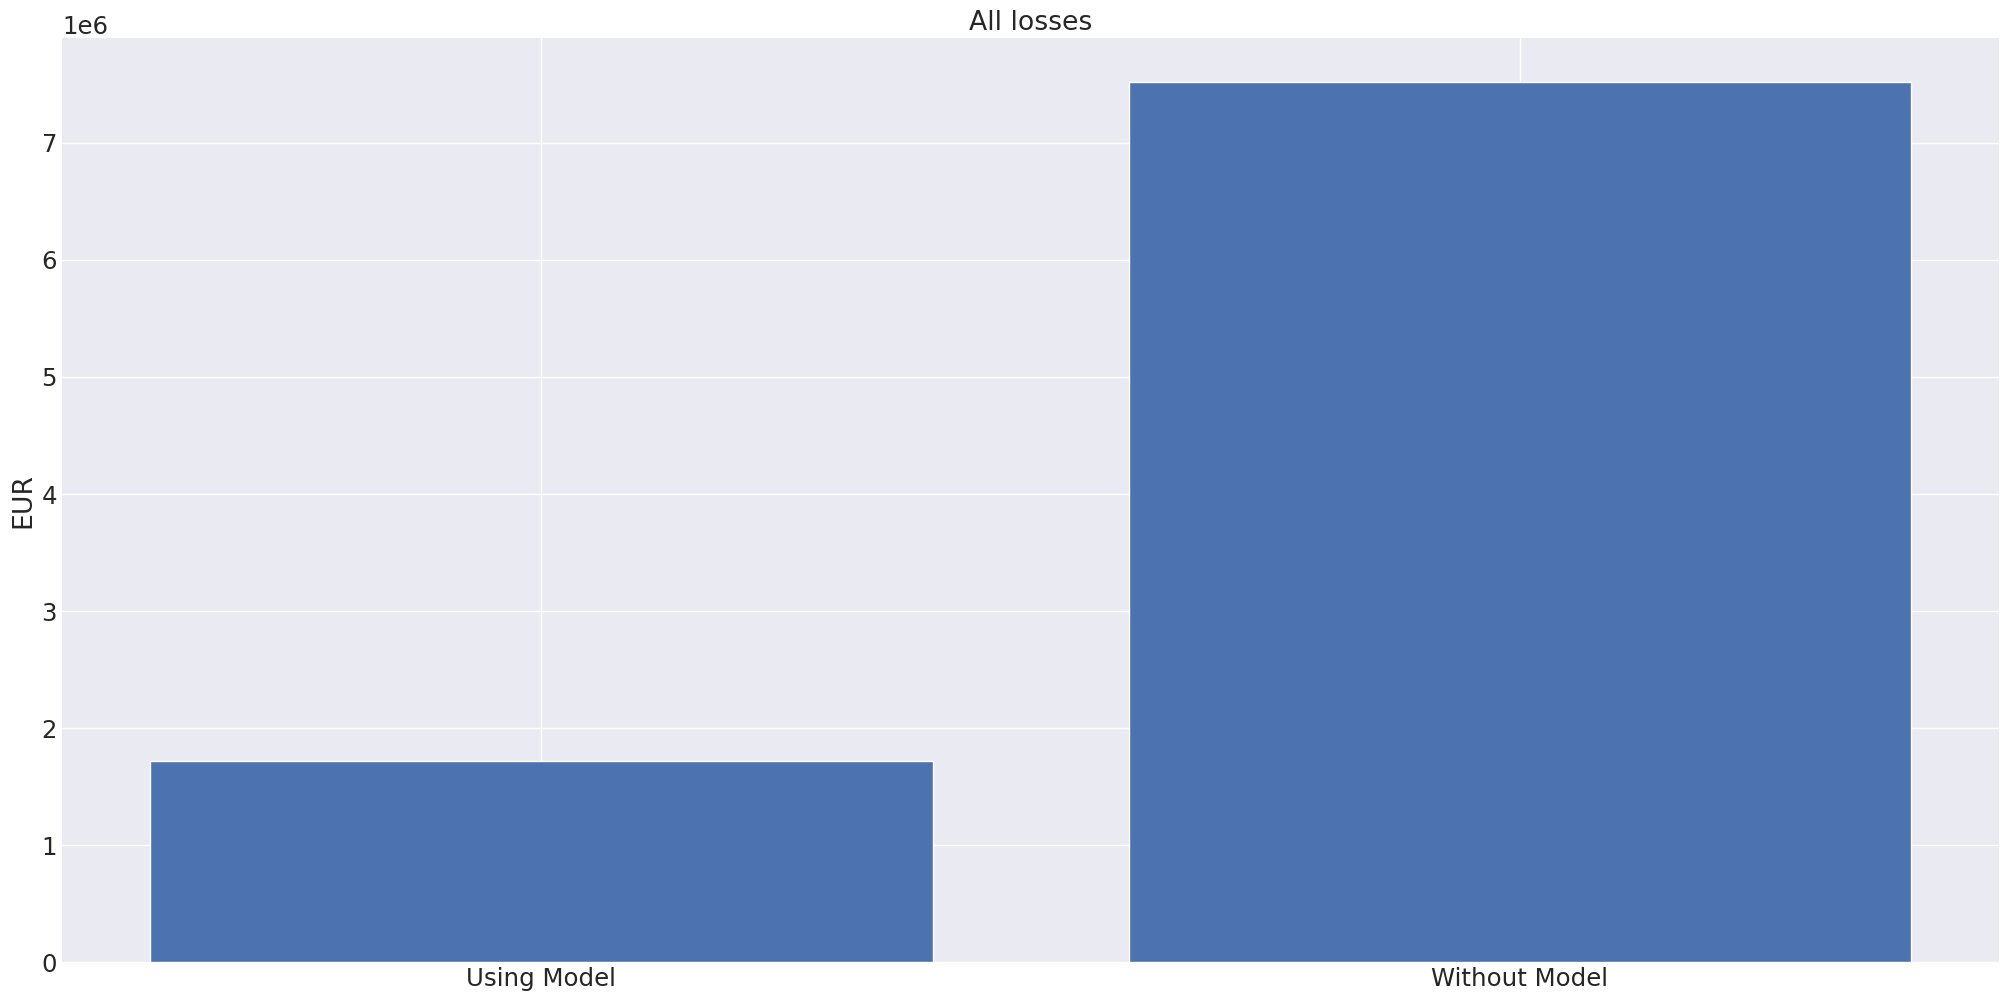

In [120]:
y = [exited_total.sum() - exited_redeemed.sum(), exited_total.sum()]
x = ['Using Model', 'Without Model']

plt.bar(x, y)
plt.title('All losses')
plt.ylabel('EUR')
plt.show()

### 9.2.4 Berapa perkiraan pengembalian, dalam hal pendapatan, jika perusahaan menggunakan model ini untuk mencegah churn pelanggan?

In [121]:
print('Tingkat churn akan menjadi {:.2}%.'.format(1 - percentage_loss))

Tingkat churn akan menjadi 0.23%.
